# Part 1: Data Understanding

## Loading and First Inspection

We start by loading the raw dataset and performing a first structural inspection.  
This step helps us understand the **size**, **number of features**, and **data types** before making any assumptions or transformations.

In [1]:
import pandas as pd

df = pd.read_csv("datasets/Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   dateAdded           10000 non-null  object 
 2   dateUpdated         10000 non-null  object 
 3   address             10000 non-null  object 
 4   categories          10000 non-null  object 
 5   primaryCategories   10000 non-null  object 
 6   city                10000 non-null  object 
 7   country             10000 non-null  object 
 8   keys                10000 non-null  object 
 9   latitude            10000 non-null  float64
 10  longitude           10000 non-null  float64
 11  menuPageURL         1679 non-null   object 
 12  menus.amountMax     10000 non-null  float64
 13  menus.amountMin     10000 non-null  float64
 14  menus.currency      10000 non-null  object 
 15  menus.dateSeen      10000 non-null  object 
 16  menus

From the output of `df.info()`, we observe that the dataset contains **10,000 observations** and **24 features**. Most variables are stored as `object`, even when they represent dates or structured information, suggesting that several columns may benefit from type conversion in later steps.  

Additionally, some features present **missing values** (e.g. menu URLs, descriptions, postal codes), while others are complete. At this stage, we do not apply any cleaning: the goal is simply to assess the raw structure of the data and identify aspects that require deeper investigation in the following sections.

### ID and Name

In [2]:
counts = df['id'].value_counts()
dupes = counts[counts > 1]
rowsWithDups = df[df['id'].duplicated(keep=False)].sort_values('id')
print(f"Number of duplicated IDs: {len(dupes)}")

Number of duplicated IDs: 1518


We can see that ID is not unique, but it represents the ID of the business. So an ID should be connected with the name of the business.

We will test in two different cases:
1. Each id has only one name?
2. Each name has only one id?

In [3]:
# First theory: each id has only one name

byID = df.groupby('id')['name'].nunique() # number of unique names per id

print("Distinct ids:", byID.size)
print("Ids with exactly 1 name:", int((byID == 1).sum()), f"({(byID == 1).mean():.2%})")
print("Ids with >1 name (anomalies):", int((byID > 1).sum()))

# printing somes anomalies
if (byID > 1).any():
    sample_ids = byID[byID > 1].index[:5]
    print("\nSample (id ↔ names):")
    print(
        df.loc[df['id'].isin(sample_ids), ['id','name']]
          .drop_duplicates()
          .sort_values(['id','name'])
          .head(20)
          .to_string(index=False)
    )

Distinct ids: 2285
Ids with exactly 1 name: 2285 (100.00%)
Ids with >1 name (anomalies): 0


In [4]:
# Second theory: each name has only one 

# Test B — name → id
byName = df.groupby('name')['id'].nunique() # number of unique ids per name

print("Distinct names:", byName.size)
print("Names with exactly 1 id:", int((byName == 1).sum()), f"({(byName == 1).mean():.2%})")
print("Names with >1 id (chains/homonyms):", int((byName > 1).sum()))

# printing somes anomalies
if (byName > 1).any():
    sample_names = byName[byName > 1].sort_values(ascending=False).index[:5]
    print("\nSample (name <-> ids):")
    print(
        df.loc[df['name'].isin(sample_names), ['name','id','city','province']]
          .drop_duplicates()
          .sort_values(['name','city','province','id'])
          .head(5)
          .to_string(index=False)
    )

Distinct names: 1827
Names with exactly 1 id: 1656 (90.64%)
Names with >1 id (chains/homonyms): 171

Sample (name <-> ids):
                 name                   id           city province
Little Caesar's Pizza AWEKUydU3-Khe5l_edBW         Dayton       OH
Little Caesar's Pizza AWEKTwbZa4HuVbedMB00       Española       NM
Little Caesar's Pizza AVwdCs4skufWRAb51sjs       Hartford       WI
Little Caesar's Pizza AVwdDoS8_7pvs4fz1zoW Hendersonville       NC
Little Caesar's Pizza AVweURCU_7pvs4fzB7G2   Indianapolis       IN


From the code above we can answer the two questions:
1. Yes. Each ID maps to exactly one name (for that business).
2. No. 171 names map to more than one ID, so name is not unique and cannot be used as a key.

### Date columns

The columns in question are dateAdded, dateUpdated and menu.dateSeen. For menu.dateSeen we can just convert it but for dateAdded and dateUpdated there's something more.

The hypothesis is, for this features, that:
- dateAdded is the first observation for the business
- dateUpdated is the last 

In [5]:
da = pd.to_datetime(df['dateAdded'])
du = pd.to_datetime(df['dateUpdated'])

# invarianti base
okAdded  = (da.groupby(df['id']).transform('min') == da).all()
okUpdated = (du.groupby(df['id']).transform('max') == du).all()
okOrder  = (du >= da).all()

print("dateAdded is first per id:", okAdded)
print("dateUpdated is last per id:", okUpdated)
print("dateUpdated >= dateAdded:", okOrder)

dateAdded is first per id: True
dateUpdated is last per id: True
dateUpdated >= dateAdded: True


This observation confirms our initial hypothesis: several columns stored as `object` types actually encode temporal information. From these fields, it would be possible to engineer additional features such as:

- the **age of the business** (derived from the creation date),
- the **time since the last update** of the record.

Such features could provide valuable signals in downstream analyses or modeling tasks.  
However, at this stage we deliberately postpone feature engineering. Instead, we focus on converting variables to more appropriate data types (e.g. parsing dates), in order to work with a cleaner and more semantically correct representation of the data in the next steps.

In [6]:
dateCols = ['dateAdded', 'dateUpdated', 'menus.dateSeen']
for c in dateCols:
    df[c] = pd.to_datetime(
        df[c], 
        errors='coerce', # coercing errors to NaT
        utc=True,  # assuming UTC timezone
        format="mixed" # letting pandas infer format
        ) 

df[dateCols].dtypes

dateAdded         datetime64[ns, UTC]
dateUpdated       datetime64[ns, UTC]
menus.dateSeen    datetime64[ns, UTC]
dtype: object

### String columns

Several variables in the dataset represent **pure textual or categorical information**, such as identifiers, location fields, and descriptive attributes (e.g. IDs, addresses, categories, city and province names, menu descriptions, and currency codes).

For these columns, the most appropriate choice is to explicitly cast them to a **string type** and apply basic normalization (e.g. consistent casing, trimming whitespace). This ensures a uniform representation across the dataset, reduces the risk of hidden inconsistencies, and prepares the data for reliable grouping, filtering, and analysis in later stages.

In [7]:
from src.utilities import clean_strings

stringCols = [
    'id', 'address', 'categories',
    'primaryCategories', 'city', 'country',
    'keys', 'menuPageURL', 'menus.currency',
    'menus.description', 'menus.name','name',
    'priceRangeCurrency','province'
    ]

df[stringCols] = df[stringCols].astype('string') # convert to string dtype

for c in stringCols:
    df[c] = clean_strings(df[c])

df['city'] = df['city'].str.title()
for c in ['country','province','menus.currency','priceRangeCurrency']:
    df[c] = df[c].str.upper()

### Numeric Columns
It is appropriate to assign numeric value to some columns: only postalCode in this case.

In [8]:
df['postalCode'] = pd.to_numeric(
    df['postalCode'],
    errors='coerce', # coercing errors to NaN
    downcast='integer' # downcasting to smallest integer subtype
    )

## Data Dictionary

* **id** - Business ID (unique per business; repeats across rows because each row is a menu item).
* **dateAdded** - First time the business record appears (UTC).
* **dateUpdated** - Last time the business record was seen/updated (UTC, ≥ `dateAdded`).
* **address** - Street address.
* **categories** - Raw categories collected from sources.
* **primaryCategories** - Normalized/primary categories.
* **city** - City.
* **country** - Country code (e.g., US).
* **keys** - Source merge keys for reconciliation (serialized list).
* **latitude** - Latitude.
* **longitude** - Longitude.
* **menuPageURL** - URL of the menu page.
* **menus.amountMax** - Max price for the menu item/size.
* **menus.amountMin** - Listed/min price for the menu item.
* **menus.currency** - Currency for menu prices.
* **menus.dateSeen** - When that item/price was observed (UTC).
* **menus.description** - Menu item description.
* **menus.name** - Menu item name.
* **name** - Business name (not unique; a name can map to multiple IDs).
* **postalCode** - ZIP postal code.
* **priceRangeCurrency** - Currency of the business-level price band.
* **priceRangeMin** - Lower bound of the business price band.
* **priceRangeMax** - Upper bound of the business price band.
* **province** - State/province code (e.g., CA, NY).

For easier ffurther analisys the dataframe can be divided in two sub-tables:
1. Business: the table for unique ids
2. Menu items: it's useless to create another tabel just for that, we already have the full dataset.

In [9]:
dfUniqueID = df.drop_duplicates(subset=['id']).reset_index(drop=True)
dfUniqueID.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,menus.currency,menus.dateSeen,menus.description,menus.name,name,postalCode,priceRangeCurrency,priceRangeMin,priceRangeMax,province
0,AVz3Y-7h3D1zeR_xDAqm,2017-06-30 05:05:40+00:00,2019-05-01 15:43:09+00:00,4203 E Kiehl Ave,"Pizza,Restaurant,American restaurants,Pizza Pl...",Accommodation & Food Services,Sherwood,US,us/ar/sherwood/4203ekiehlave/-1051391616,34.832300,...,USD,NaT,<NA>,Cheese Pizza,Shotgun Dans Pizza,72120.0,USD,0,25,AR
1,AVweGPFF_7pvs4fzAAzQ,2016-04-02 04:02:49+00:00,2019-05-01 15:27:50+00:00,25 E Camelback Rd,"Pizza,Pizza Place,Restaurants",Accommodation & Food Services,Phoenix,US,us/az/phoenix/25ecamelbackrd/-727422936,33.509266,...,USD,NaT,<NA>,Pizza Cookie,Sauce Pizza Wine,85012.0,USD,0,25,AZ
2,AVwdRGa9_7pvs4fz4E3K,2016-03-03 18:39:49+00:00,2019-05-01 12:52:25+00:00,3703 Paxton Ave,"Restaurant,Pizza Place,Restaurants",Accommodation & Food Services,Cincinnati,US,us/oh/cincinnati/3703paxtonave/-619797122,39.144883,...,USD,NaT,a saucelessampcomma double cheese pizza with a...,Pizza Blanca,Mios Pizzeria,45209.0,USD,0,25,OH
3,AVwdX4psIN2L1WUfvJB1,2016-03-29 05:08:59+00:00,2019-05-01 12:52:20+00:00,30495 John R Rd,"Pizza,Carry-out food,Pizza Place,Restaurants",Accommodation & Food Services,Madison Heights,US,us/mi/madisonheights/30495johnrrd/-874863116,42.516669,...,USD,NaT,<NA>,Small Pizza,Hungry Howies Pizza,48071.0,USD,25,40,MI
4,AVwdaeTtkufWRAb55pSH,2016-03-31 02:34:04+00:00,2019-05-01 12:50:45+00:00,3600 Eastern Ave,"Pizza,American restaurants,Pizza Place,Pizza e...",Accommodation & Food Services,Baltimore,US,us/md/baltimore/3600easternave/-1270965359,39.286630,...,USD,2016-03-31 02:34:04+00:00,<NA>,Pizza Sub,Spartan Pizzeria,21224.0,USD,0,25,MD


## Data Analisys questions

1. What are the most bought pizas accross the USA? 
2. Costal cities have higher prices than internal cities?
3. Is there a statistically significant difference in the average menu price across the main pizza categories?
4. Do the business-level price ranges (priceRangeMin/Max) align with actual menu item prices? How consistent is that alignment by state?

# Part 2: Data Cleaning & Preparation

## Handling missing values
From dataset infos, after we have converted all of them either specific values or NaN (NaT for dates), it's possible to see that features with missing values are:
1. menuPageURL
2. menus.dateSeen
3. menus.description
4. postalCode

In [10]:
missing = df.isna().mean().sort_values(ascending=False)*100

for col, pct in missing[missing > 0].items():
    print(f"{col:25s}: {pct:5.2f}% missing")

menuPageURL              : 83.21% missing
menus.dateSeen           : 79.72% missing
menus.description        : 62.82% missing
postalCode               :  0.27% missing


menuPageURL, menus.dateSeen and menus.description are (basically) useless, we can drop it. PostalCode does not have so much missing values, we can keep it and pay attention later.

In [11]:
df.drop(columns=
    ["menuPageURL", 
    "menus.dateSeen", 
    "menus.description"], 
    axis=1, 
    inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  10000 non-null  string             
 1   dateAdded           10000 non-null  datetime64[ns, UTC]
 2   dateUpdated         10000 non-null  datetime64[ns, UTC]
 3   address             10000 non-null  string             
 4   categories          10000 non-null  string             
 5   primaryCategories   10000 non-null  string             
 6   city                10000 non-null  string             
 7   country             10000 non-null  string             
 8   keys                10000 non-null  string             
 9   latitude            10000 non-null  float64            
 10  longitude           10000 non-null  float64            
 11  menus.amountMax     10000 non-null  float64            
 12  menus.amountMin     10000 non-nul

## Handling duplicates

In [12]:
from src.utilities import check_row_duplicates

originalShape = df.shape

for row in check_row_duplicates(df).itertuples():
    df.drop(index=row.Index, inplace=True)
    
print(f"Removed {originalShape[0] - df.shape[0]} duplicate rows.")

Removed 632 duplicate rows.


## Correction of Inconsistencies and formatting
Correction of Dtypes has already been done on part 1. Checking on values is needed only on columns: country, menus.currency, priceRangeCurrency.

In [13]:
print('Country in dataset are only "US": ', (df['country'] == 'US').all())
print('Menu currency is always "USD": ', (df['menus.currency'] == 'USD').all())
print('Price range currency is always "USD": ', (df['priceRangeCurrency'] == 'USD').all())

Country in dataset are only "US":  True
Menu currency is always "USD":  True
Price range currency is always "USD":  True


### menus.name

In [14]:
df['menus.name'].nunique()

4653

Clearly, `menus.name` is a noisy field: item names are inconsistently formatted, often include marketing text, and mix together multiple pieces of information (size, crust, dietary claims, product type, etc.).  
To make this column usable and interpretable, we apply a **two-step approach**: normalization + semantic enrichment, using code in `src/cleaner.py`.

First, we standardize each item name with a lightweight normalization routine (`_basic_normalize`): lowercasing, removing HTML entities and non-alphanumeric characters, and harmonizing separators. We also remove common “noise” expressions (e.g., *signature*, *special*, and even the word *pizza* when appropriate) to reduce redundant vocabulary.

Next, we enrich the text by extracting explicit, human-readable attributes with regex patterns (`_extract_attributes`). In particular, we detect:
- **Size** (e.g., small/medium/large/xlarge),
- **Dietary labels** (e.g., gluten-free, vegan, vegetarian, keto),
- **Product form** (e.g., slice, calzone, stromboli, garlic bread, pasta),
- **Crust style** (e.g., thin, deep-dish, pan, stuffed),
- A coarse **topping count** when stated (1, 2, 3+ toppings),
- Additional **style tags** (e.g., margherita, bbq, buffalo).

These signals are encoded as **binary features** (dummy columns) and also injected into an **enriched text representation** through structured tokens (e.g., `size=large`, `crust=thin`, `diet=vegan`). This hybrid representation preserves interpretability while making the text easier to cluster.

The enriched strings are then vectorized with **TF-IDF** (including n-grams) to obtain a scalable sparse representation. Clustering is performed with **BIRCH**, which efficiently groups similar menu items without requiring expensive pairwise distance computations and works well on large sparse feature spaces.

Finally, each cluster is summarized in a compact and interpretable way: we assign a representative label (the most frequent original value in the cluster) and produce a cluster report with:
- cluster size (weighted by frequency in the dataset),
- top examples,
- top TF-IDF keywords,
- and (if enabled) attribute prevalence within the cluster.

This produces cleaner, more consistent menu item labels and structured features that can be used downstream for analysis and modeling.

In [15]:
import src.cleaner as cleaner
df, cluster_summary = cleaner.clean_categorical_column(
    df=df,
    column="menus.name",
    new_column="menus.cleanedNames",
    cluster_id_column="menus.cluster_id",
    birch_threshold=0.6,
    dummy_prefix ="menu_"
)

# --- AFTER CLUSTERING: group rare cleaned names into "OTHER" ---
print("Unique cleaned names (before):", df["menus.cleanedNames"].nunique(dropna=True))

MIN_COUNT = 30  # adjust: 10 / 20 / 30 / 50 depending on desired compression

vc = df["menus.cleanedNames"].value_counts(dropna=True)
keep = vc[vc >= MIN_COUNT].index

df["menus.cleanedNames"] = df["menus.cleanedNames"].where(
    df["menus.cleanedNames"].isin(keep),
    "OTHER"
)

print("Unique cleaned names (reduced):", df["menus.cleanedNames"].nunique(dropna=True))
print("Share OTHER:", (df["menus.cleanedNames"] == "OTHER").mean().round(3))

Unique cleaned names (before): 1890
Unique cleaned names (reduced): 43
Share OTHER: 0.611


In [16]:
RAW_COL = "menus.name"
CLEAN_COL = "menus.cleanedNames"
CLUSTER_COL = "menus.cluster_id"

TOP_K = 15

n_rows = len(df)
n_raw = df[RAW_COL].nunique(dropna=True)
n_clean = df[CLEAN_COL].nunique(dropna=True)
n_clusters = df[CLUSTER_COL].nunique(dropna=True)

metrics = pd.DataFrame({
    "metric": [
        "Dataset rows",
        "Unique raw menu names (before)",
        "Unique cleaned names (after)",
        "Number of clusters",
        "Cardinality reduction",
    ],
    "value": [
        n_rows,
        n_raw,
        n_clean,
        n_clusters,
        f"{(1 - (n_clean / n_raw)) * 100:.1f}%" if n_raw else "n/a",
    ]
})

# ============================================================
# BEFORE: raw menu names (high cardinality)
# ============================================================

before = (
    df[RAW_COL]
    .fillna("")
    .value_counts()
    .head(TOP_K)
    .rename_axis("menus.name (raw)")
    .reset_index(name="count")
)

before["share_%"] = (before["count"] / n_rows * 100).round(2)

# ============================================================
# AFTER: cluster summary (from cleaner)
# ============================================================

after = (
    cluster_summary
    .sort_values("n_rows", ascending=False)
    .head(TOP_K)
)

# ============================================================
# DISPLAY
# ============================================================

print("\n=== SUMMARY METRICS ===")
display(metrics)

print("\n=== BEFORE: Raw menu names (top frequency) ===")
display(before)

print("\n=== AFTER: Clustered menu items (top clusters) ===")
display(after)



=== SUMMARY METRICS ===


,metric,value
0,Dataset rows,9368
1,Unique raw menu names (before),4653
2,Unique cleaned names (after),43
3,Number of clusters,1890
4,Cardinality reduction,99.1%



=== BEFORE: Raw menu names (top frequency) ===


,menus.name (raw),count,share_%
0,Cheese Pizza,279,2.98
1,White Pizza,197,2.1
2,Hawaiian Pizza,135,1.44
3,Buffalo Chicken Pizza,104,1.11
4,Pizza,99,1.06
5,Margherita Pizza,96,1.02
6,Veggie Pizza,81,0.86
7,Bbq Chicken Pizza,70,0.75
8,Pizza Burger,66,0.7
9,Greek Pizza,64,0.68



=== AFTER: Clustered menu items (top clusters) ===


,cluster_id,n_rows,cluster_rep,top_examples,top_keywords,p_crust_cauliflower,p_crust_chicago,p_crust_deepdish,p_crust_glutenfree,p_crust_handtossed,...,p_size_family,p_size_kids,p_size_large,p_size_medium,p_size_personal,p_size_small,p_size_xlarge,p_topping_1,p_topping_2,p_topping_3plus
0,973,677,Pizza,"[Pizza, 1 Topping Pizza, Special Pizza, 2 Topp...","[spinaci, corner, pizzazz, pisa, fritta, mare,...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001477,0.0,0.0,0.023634,0.010340,0.035451
1,194,314,Cheese Pizza,"[Cheese Pizza, Classic Cheese Pizza, 7 Cheese ...","[cheese, premium]",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.006369,0.003185,0.000000
2,33,242,White Pizza,"[White Pizza, Gourmet White Pizza, 14ampquot W...","[white, style white, style, white eggplant, eg...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,548,176,Veggie Pizza,"[Veggie Pizza, Vegetarian Pizza, Veggie Lovers...","[vegetarian, diet vegetarian, diet, vegetarian...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,1701,155,Hawaiian Pizza,"[Hawaiian Pizza, Catering Hawaiian Pizza, Hawa...","[hawaiian, catering, delight, 12ampquot hawaii...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
5,770,145,Bbq Chicken Pizza,"[Bbq Chicken Pizza, BBQ Chicken Pizza, Barbecu...","[bbq, style bbq, style, chicken, bbq chicken, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
6,84,142,Margherita Pizza,"[Margherita Pizza, Pizza Margherita, 16ampquot...","[margherita, style margherita, style, pizza16,...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
7,739,111,Buffalo Chicken Pizza,"[Buffalo Chicken Pizza, Buffalo Chicken Cheese...","[buffalo chicken, buffalo, style buffalo, chic...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
8,166,103,Pizza By the Slice,"[Pizza By the Slice, Pizza By The Slice, Pizza...","[kind slice, slice, kind, 1item, diced, nonna,...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.038835,0.019417,0.000000
9,825,97,Sicilian Pizza,"[Sicilian Pizza, Sicilian Special Pizza, Grand...","[sicilian, crust sicilian, crust, grandma39s, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.010309,0.000000,0.000000


### Menu name cleaning – summary report

The original `menus.name` column exhibits very high cardinality and substantial noise, with **4,653 unique values** across **9,368 rows**, largely driven by inconsistent formatting, marketing terms, and redundant variants of the same items.

After applying semantic normalization and clustering, the effective number of **cleaned menu names is reduced to 43**, corresponding to a **99.1% reduction in cardinality**. Internally, the algorithm identifies **1,890 fine-grained clusters**, which capture subtle semantic differences between items, while the final cleaned labels provide a compact and stable representation suitable for analysis.

A comparison of the most frequent raw values (e.g. *Cheese Pizza*, *White Pizza*, *Hawaiian Pizza*) with the largest clusters shows that the clustering process successfully consolidates equivalent or near-equivalent items under coherent categories. The cluster summaries further confirm semantic consistency, with dominant patterns reflecting meaningful attributes such as product type (e.g. *slice*, *sub*, *burger*), style (e.g. *Sicilian*, *Margherita*), and dietary orientation.

Overall, this step dramatically simplifies the feature space while preserving interpretability, enabling downstream modeling and exploratory analysis without losing the underlying structure of the menu data.

In [17]:
df.columns = df.columns.str.strip()

col_old = "menus.name"
col_new = "menus.cleanedNames"

mapping = (
    df[[col_old, col_new]]
    .dropna()
    .drop_duplicates()
)

filtered = mapping[
    (mapping[col_old] != mapping[col_new]) &
    (mapping[col_new] != "OTHER") &
    (mapping[col_new] != "Pizza")
]

# Un elemento per ciascuna categoria diversa
examples = (
    filtered
    .groupby(col_new, group_keys=False)
    .sample(n=1, random_state=42)
    .sample(n=5, random_state=42)
)

examples

,menus.name,menus.cleanedNames
818,The Jj Twig or Mexican Pizza,Mexican Pizza
6635,Margherita Mushroom Pizza,Margherita Pizza
9197,Pizza Margarita,Margarita Pizza
7759,Pizza Fries Or Mozzarella Fries,Pizza Fries
2068,Build Your Own Skinny Pizza,Build Your Own Pizza


## Handling Outliers
For outliers analysis we need to check only on numeric values.

In [18]:
obsBeforeCleaning = df.shape[0]

numericCols = df.select_dtypes(include=['number']).columns.tolist()
print(df[numericCols].describe())

          latitude    longitude  menus.amountMax  menus.amountMin  \
count  9368.000000  9368.000000      9368.000000      9368.000000   
mean     38.396025   -90.084907        13.934071        13.320899   
std       4.535688    17.384233        17.675416        10.236093   
min      21.421326  -157.802443         0.000000         0.000000   
25%      34.746260  -104.924182         8.490000         8.000000   
50%      40.109370   -82.898020        13.250000        12.950000   
75%      40.887121   -75.192900        17.950000        16.960000   
max      64.850500   -71.946170      1395.000000       243.000000   

         postalCode  priceRangeMin  priceRangeMax  menus.cluster_id  \
count   9343.000000    9368.000000    9368.000000            9368.0   
mean   45992.193835       4.603437      27.728651        913.672182   
std    31949.317338       9.786576       5.995695        560.133969   
min    10001.000000       0.000000       7.000000               0.0   
25%    14216.000000    

### Latitude
Latitude is a value that must be in range -90 degree (south pole) and +90 degree (north pole) wehre 0 is the equator noting that, for a dataset of pizza business and restaraunt, values near bounds may be considered outliers. Considering that all the dataset restaurants are in USA we consider everything under 18.9 and above 71.4 as **outliers**.

In [19]:
print(f"Max latitude is: {df['latitude'].max()}")
print(f"Min latitude is: {df['latitude'].min()}")

badLat = df['latitude'].notna() & ~df['latitude'].between(18.9, 71.4)
print("Outliers (global lat):", len(df[badLat]))

Max latitude is: 64.8505
Min latitude is: 21.421326
Outliers (global lat): 0


### Longitude
Longitude has a range that varies from -180 to 180 where 0 is Greenwich meridian. In USA covers a range of [-179.14, -66.9] and we will considers outliers everything outside that range.

In [20]:
print(f"Max longitude is: {df['longitude'].max()}")
print(f"Min longitude is: {df['longitude'].min()}")

badLon = df['longitude'].notna() & ~df['longitude'].between(-179.14, -66.9)
print("Outliers (global lon):", len(df[badLon]))

Max longitude is: -71.94617
Min longitude is: -157.802443
Outliers (global lon): 0


### priceRangeMax
In order to identify outliers an idea is to plot an histogram and delete the outliers manually.

In [21]:
tableAddedPMax = dfUniqueID[['dateAdded', 'priceRangeMax']].copy()
tableUpdatedPMax = dfUniqueID[['dateUpdated', 'priceRangeMax']].copy()

yearsAdded = tableAddedPMax['dateAdded'].dropna().dt.year.unique()
yearsUpdated = tableUpdatedPMax['dateUpdated'].dropna().dt.year.unique()

years = sorted(set(yearsAdded) | set(yearsUpdated))

for year in years:
    print(f"\nYear {year}:")
    
    sub_added = tableAddedPMax[tableAddedPMax['dateAdded'].dt.year == year]
    sub_updated = tableUpdatedPMax[tableUpdatedPMax['dateUpdated'].dt.year == year]
    
    prices = sorted(set(sub_added['priceRangeMax'].dropna().unique()) |
                    set(sub_updated['priceRangeMax'].dropna().unique()))
    
    for p in prices:
        count_added = (sub_added['priceRangeMax'] == p).sum()
        count_updated = (sub_updated['priceRangeMax'] == p).sum()
        total = int(count_added + count_updated)
        print(f"  price {p}: {total} occurences (dateAdded={int(count_added)}, dateUpdated={int(count_updated)})")


Year 2014:
  price 25: 5 occurences (dateAdded=5, dateUpdated=0)
  price 26: 1 occurences (dateAdded=1, dateUpdated=0)
  price 40: 5 occurences (dateAdded=5, dateUpdated=0)

Year 2015:
  price 7: 1 occurences (dateAdded=1, dateUpdated=0)
  price 10: 1 occurences (dateAdded=1, dateUpdated=0)
  price 19: 1 occurences (dateAdded=1, dateUpdated=0)
  price 20: 3 occurences (dateAdded=3, dateUpdated=0)
  price 24: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 366 occurences (dateAdded=366, dateUpdated=0)
  price 30: 2 occurences (dateAdded=2, dateUpdated=0)
  price 40: 97 occurences (dateAdded=97, dateUpdated=0)
  price 55: 4 occurences (dateAdded=4, dateUpdated=0)

Year 2016:
  price 25: 901 occurences (dateAdded=901, dateUpdated=0)
  price 30: 3 occurences (dateAdded=3, dateUpdated=0)
  price 35: 1 occurences (dateAdded=1, dateUpdated=0)
  price 40: 187 occurences (dateAdded=187, dateUpdated=0)
  price 55: 5 occurences (dateAdded=5, dateUpdated=0)

Year 2017:
  price 18: 1 occuren

There're no outliers here.

### priceRangeMin
For priceRangeMin it's possible to consider the same method as priceRangeMax.

In [22]:
tableAddedPMin = dfUniqueID[['dateAdded', 'priceRangeMin']].copy()
tableUpdatedPMin = dfUniqueID[['dateUpdated', 'priceRangeMin']].copy()

yearsAddedMin = tableAddedPMin['dateAdded'].dropna().dt.year.unique()
yearsUpdatedMin = tableUpdatedPMin['dateUpdated'].dropna().dt.year.unique()

yearsMin = sorted(set(yearsAddedMin) | set(yearsUpdatedMin))

for year in yearsMin:
    print(f"\n[priceRangeMin] Year {year}:")
    
    sub_added = tableAddedPMin[tableAddedPMin['dateAdded'].dt.year == year]
    sub_updated = tableUpdatedPMin[tableUpdatedPMin['dateUpdated'].dt.year == year]
    
    prices = sorted(set(sub_added['priceRangeMin'].dropna().unique()) |
                    set(sub_updated['priceRangeMin'].dropna().unique()))
    
    for p in prices:
        count_added = (sub_added['priceRangeMin'] == p).sum()
        count_updated = (sub_updated['priceRangeMin'] == p).sum()
        total = int(count_added + count_updated)
        print(f"  price {p}: {total} occurences (dateAdded={int(count_added)}, dateUpdated={int(count_updated)})")


[priceRangeMin] Year 2014:
  price 0: 5 occurences (dateAdded=5, dateUpdated=0)
  price 1: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 5 occurences (dateAdded=5, dateUpdated=0)

[priceRangeMin] Year 2015:
  price 0: 369 occurences (dateAdded=369, dateUpdated=0)
  price 1: 4 occurences (dateAdded=4, dateUpdated=0)
  price 10: 1 occurences (dateAdded=1, dateUpdated=0)
  price 20: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 97 occurences (dateAdded=97, dateUpdated=0)
  price 40: 2 occurences (dateAdded=2, dateUpdated=0)
  price 50: 2 occurences (dateAdded=2, dateUpdated=0)

[priceRangeMin] Year 2016:
  price 0: 901 occurences (dateAdded=901, dateUpdated=0)
  price 1: 2 occurences (dateAdded=2, dateUpdated=0)
  price 3: 1 occurences (dateAdded=1, dateUpdated=0)
  price 5: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 187 occurences (dateAdded=187, dateUpdated=0)
  price 40: 5 occurences (dateAdded=5, dateUpdated=0)

[priceRangeMin] Year 2017:
  price 0: 495 occ

### menus.amountMax
It can useful to refer for outliers search of menus.amountMax to priceRangeMax. All the values above 25% of priceRangeMax of that observation will be considered outlier and removed.

Max menus.amountMax is: 1395.0


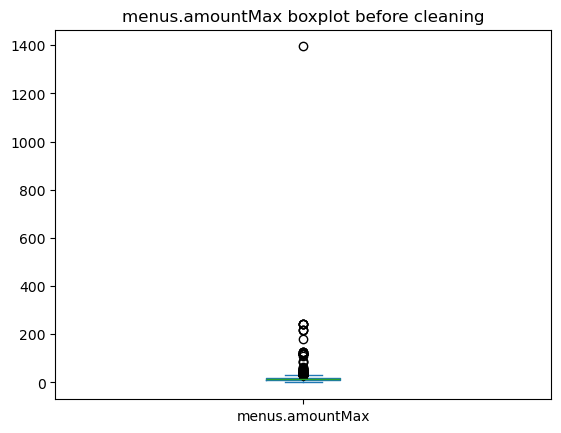

In [23]:
df['menus.amountMax'].plot.box(title='menus.amountMax boxplot before cleaning') 
print(f"Max menus.amountMax is: {df['menus.amountMax'].max()}")

In [24]:
cutRate = 1.25

before = len(df)
mask = df['menus.amountMax'] > cutRate * (df['priceRangeMax'])
removed = mask.sum()
df.drop(df[mask].index, inplace=True)
print(f"Removed {removed} outliers from menus.amountMax (>{cutRate} * priceRangeMax) out of {before} rows.")

Removed 112 outliers from menus.amountMax (>1.25 * priceRangeMax) out of 9368 rows.


Max menus.amountMax is now: 41.5


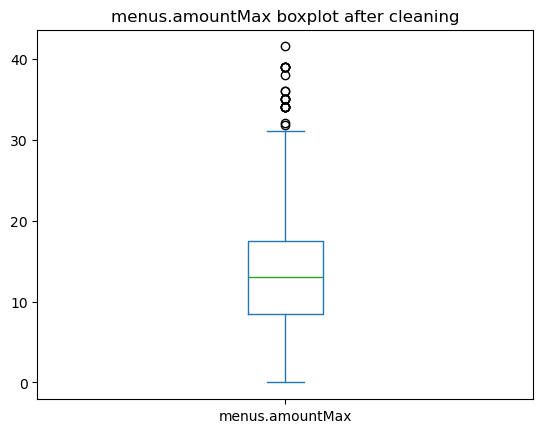

In [25]:
df['menus.amountMax'].plot.box(title='menus.amountMax boxplot after cleaning') 
print(f"Max menus.amountMax is now: {df['menus.amountMax'].max()}")

Even if the boxplot visualizes some "outliers", the max price is less than priceRangeMax.

### menus.amountMin
The problem with menus.amountMin is that almost 94% of the data are the same as menus.amountMax.

In [26]:
print("Values of menus.amountMin == menus.amountMax: ", (df['menus.amountMin'] == df['menus.amountMax']).sum())
print("Percentage of menus.amountMin == menus.amountMax: ",  f"{(df['menus.amountMin'] == df['menus.amountMax']).mean():.2%}")

Values of menus.amountMin == menus.amountMax:  8664
Percentage of menus.amountMin == menus.amountMax:  93.60%


In order to removing outliers we will use boxplots. So we will remove everything outside IQR.

<Axes: title={'center': 'menus.amountMin boxplot before cleaning'}>

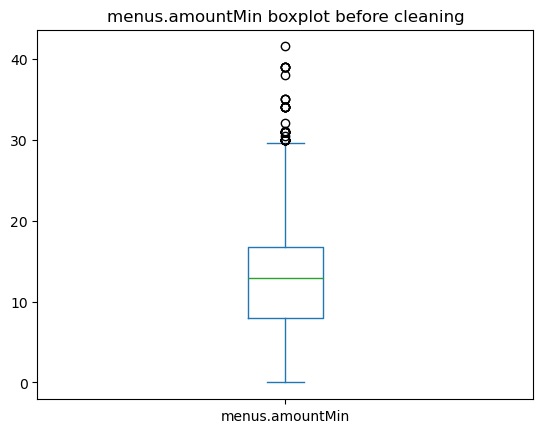

In [27]:
df['menus.amountMin'].plot.box(title='menus.amountMin boxplot before cleaning')

Removed 43 outliers from menus.amountMin outside IQR [-5.188750000000001, 29.981250000000003]


<Axes: title={'center': 'menus.amountMin boxplot after cleaning'}>

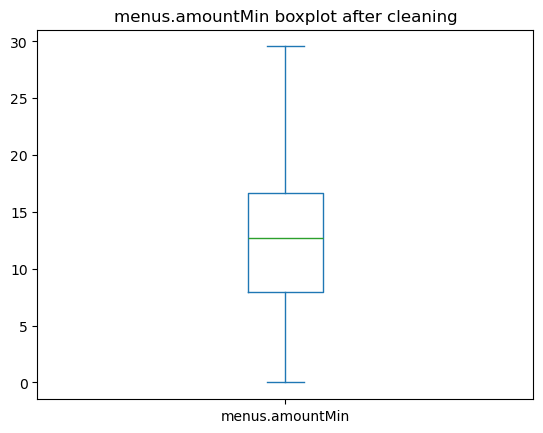

In [28]:

Q1 = df['menus.amountMin'].quantile(0.25)
Q3 = df['menus.amountMin'].quantile(0.75)
IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
high_bound = Q3 + 1.5 * IQR

before = len(df)
df = df[(df['menus.amountMin'] >= low_bound) & (df['menus.amountMin'] <= high_bound)]
print(f"Removed {before - len(df)} outliers from menus.amountMin outside IQR [{low_bound}, {high_bound}]")

df['menus.amountMin'].plot.box(title='menus.amountMin boxplot after cleaning')

### postalCode
In the USA, postal codes are ZIP codes, whose valid range is [00501, 99950]. Any value outside this range is considered an outlier.

In [29]:
mask_out = (df['postalCode'] < 501) | (df['postalCode'] > 99950) | df['postalCode'].isna()

print("Outlier postalCode rows:", mask_out.sum())

df = df[~mask_out]

Outlier postalCode rows: 25


### Resulting after cleaning

In [30]:
obsAfterCleaning = df.shape[0]
print(f"\nObservations before cleaning: {obsBeforeCleaning}")
print(f"Observations after cleaning: {obsAfterCleaning}")
print(f"Removed {obsBeforeCleaning - obsAfterCleaning} observations.")

# updating dfUniqueID after cleaning
dfUniqueID = df.drop_duplicates(subset=['id']).reset_index(drop=True)


Observations before cleaning: 9368
Observations after cleaning: 9188
Removed 180 observations.


# Part 3: Data Exploration

## Univariate Analisys

### Numeric

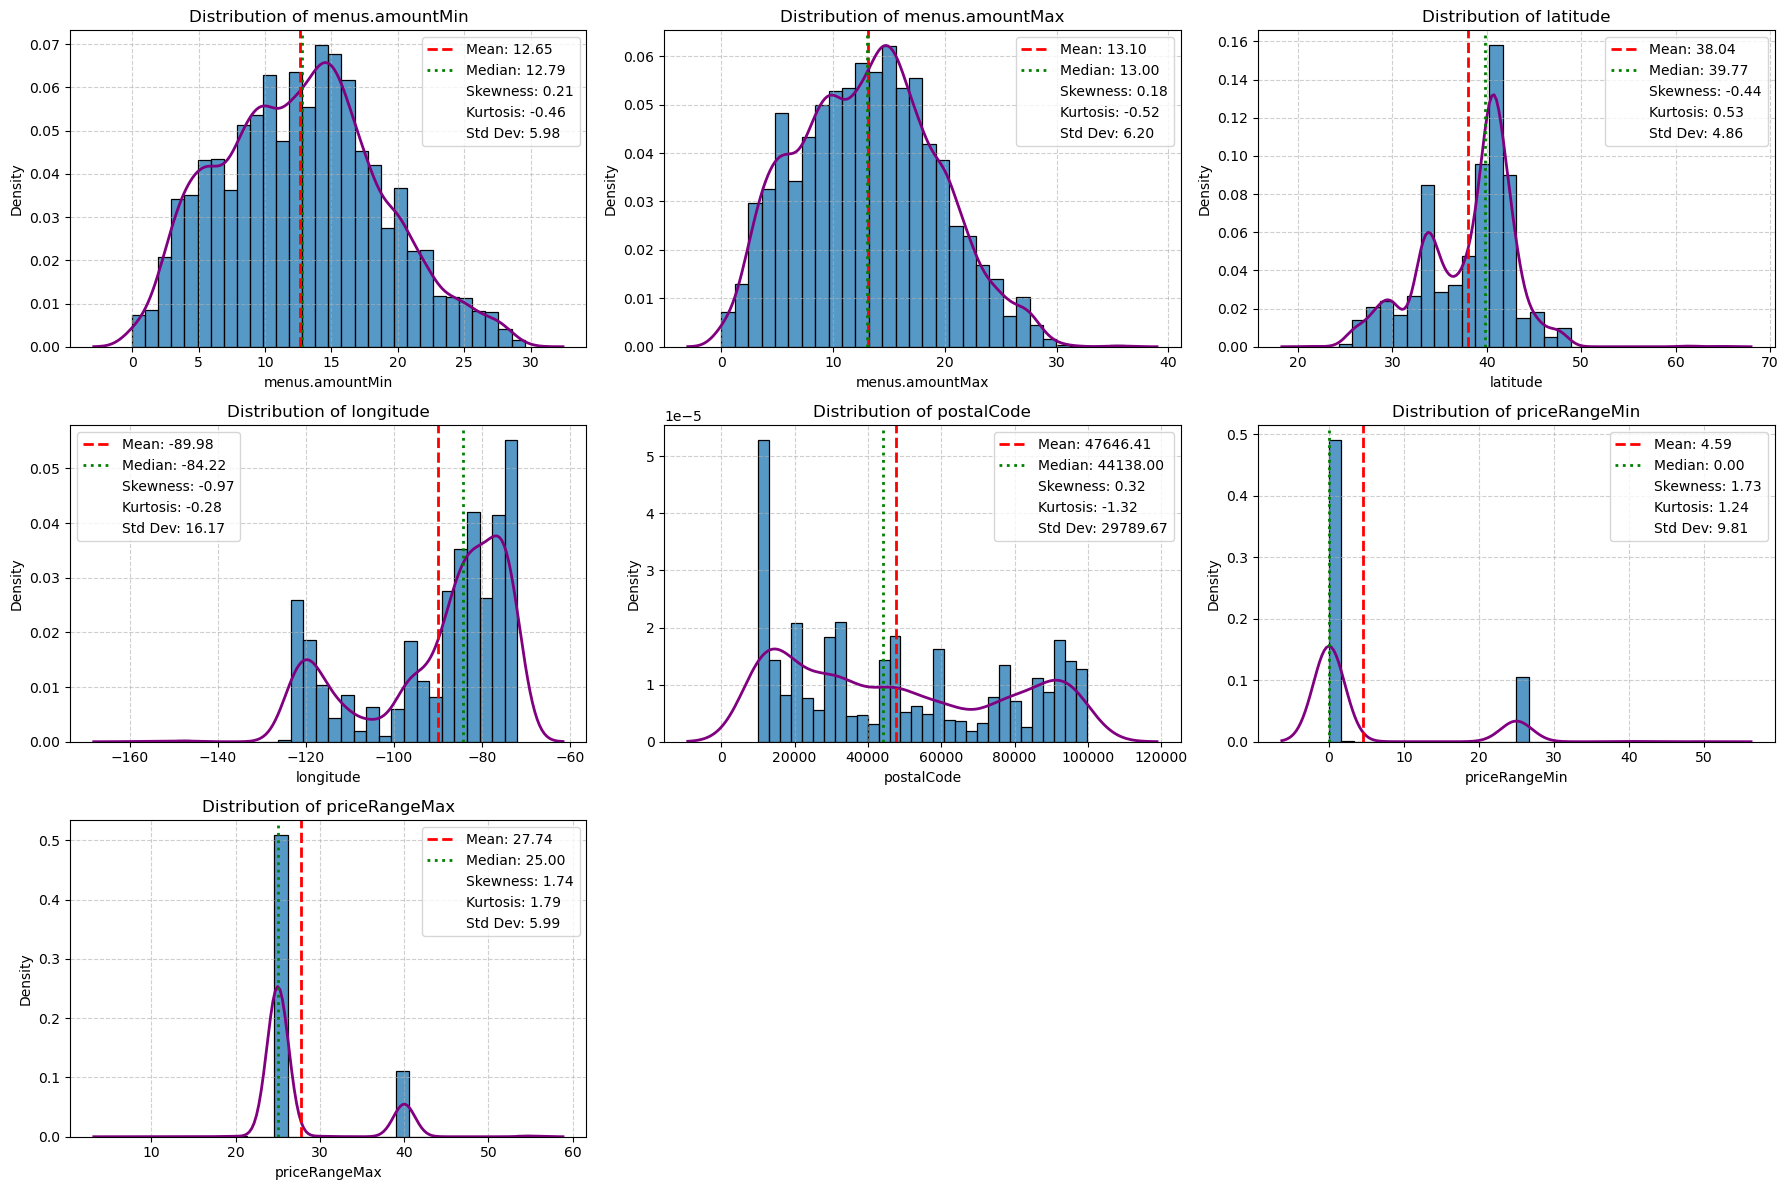

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

numericList = ['menus.amountMin', 'menus.amountMax']
numericListUniqueID = [
    'latitude', 
    'longitude', 
    'postalCode', 
    'priceRangeMin', 
    'priceRangeMax'
    ]

cols_to_plot = [(df, c) for c in numericList] + [(dfUniqueID, c) for c in numericListUniqueID] # list of (DataFrame, column) pairs

plt.figure(figsize=(18, 12))

for i, (dframe, col) in enumerate(cols_to_plot):
    s = dframe[col].dropna()

    plt.subplot(3, 3, i+1)
    ax = sns.histplot(s, bins=30, edgecolor='black', stat='density') # type: ignore
    sns.kdeplot(s, color='purple', lw=2, ax=ax) # type: ignore

    plt.title(f"Distribution of {col}")

    mean_val = s.mean()
    median_val = s.median()
    skew_val = s.skew()
    kurt_val = s.kurt()
    std_val = s.std()

    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle=':', linewidth=2,
                label=f'Median: {median_val:.2f}')

    plt.plot([], [], ' ', label=f'Skewness: {skew_val:.2f}')
    plt.plot([], [], ' ', label=f'Kurtosis: {kurt_val:.2f}')
    plt.plot([], [], ' ', label=f'Std Dev: {std_val:.2f}')

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

From this plots we can conclude that:

1. **priceRangeMax** and **priceRangeMin** tend to cluster around values close to **25** and **40**, respectively.

2. **Latitude** shows a **bimodal distribution**: values are strongly concentrated between **approximately 30° and 45°**, which indicates a higher concentration of restaurants in the **north-central region of the United States**.

3. **Longitude** is also **bimodal**, and the separation between the two peaks is even clearer:
   - one peak around **–120**, corresponding to the **West Coast**,
   - and a much stronger peak around **–80**, corresponding to the **East Coast**.

4. **menus.amountMax** and **menus.amountMin** fall within reasonable ranges, although **menus.amountMax** shows a few values above **$30**, which can be considered higher-end items.

5. Regarding **postalCode**, the situation is more complex. We observe clear spikes at specific values. This reflects the fact that **latitude and longitude are themselves clustered along a few geographic “bands”**, meaning that many restaurants come from a limited set of ZIP code regions.

### Categorial

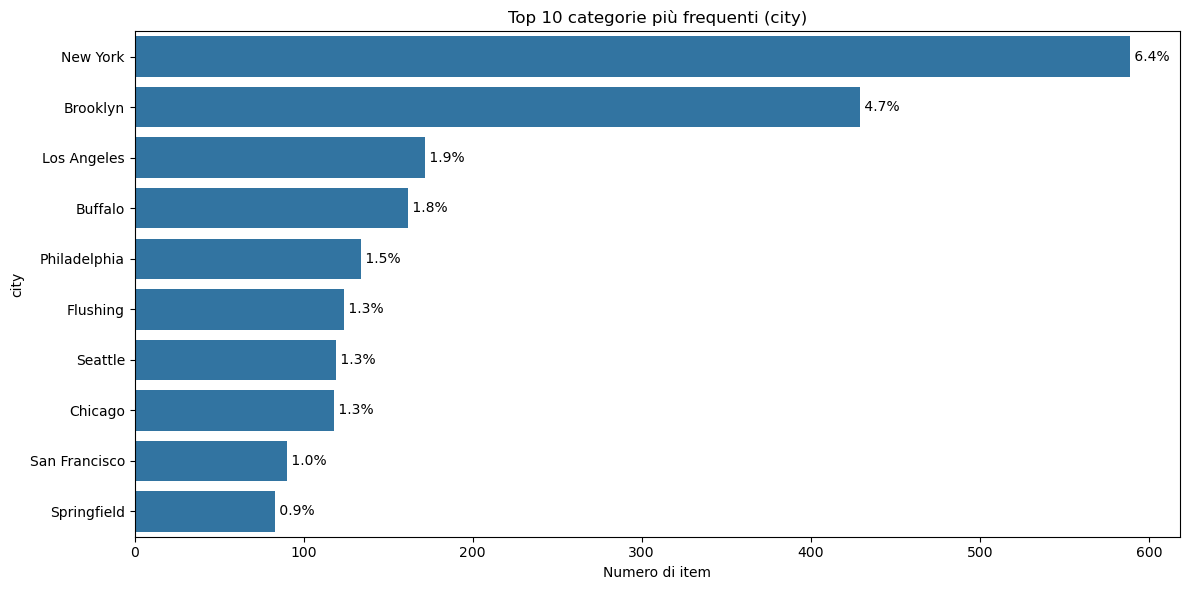

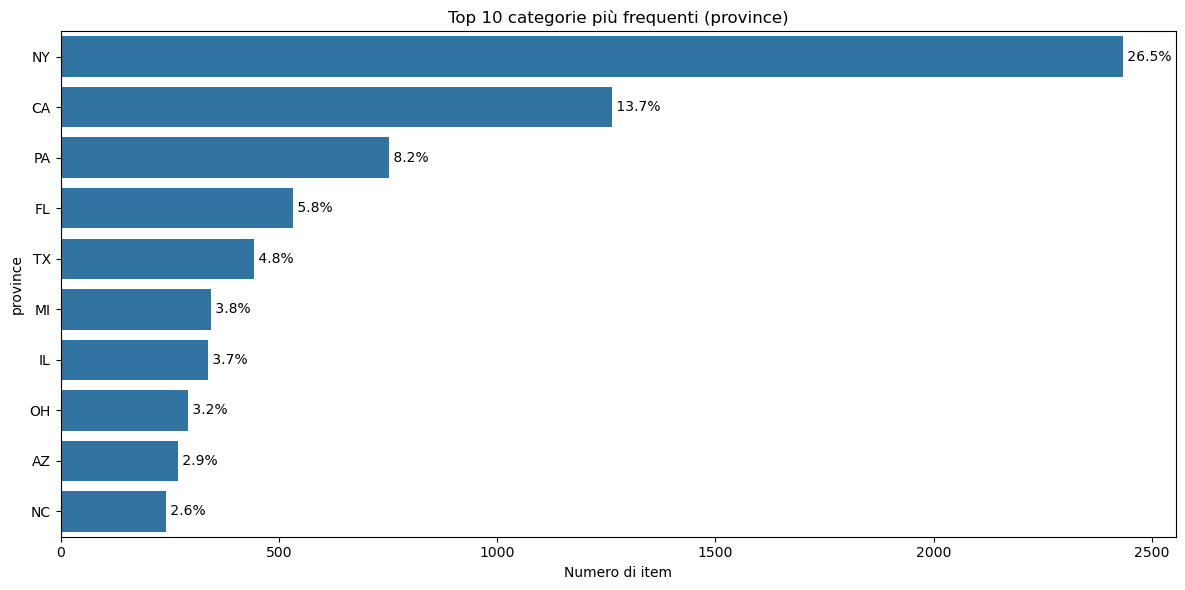

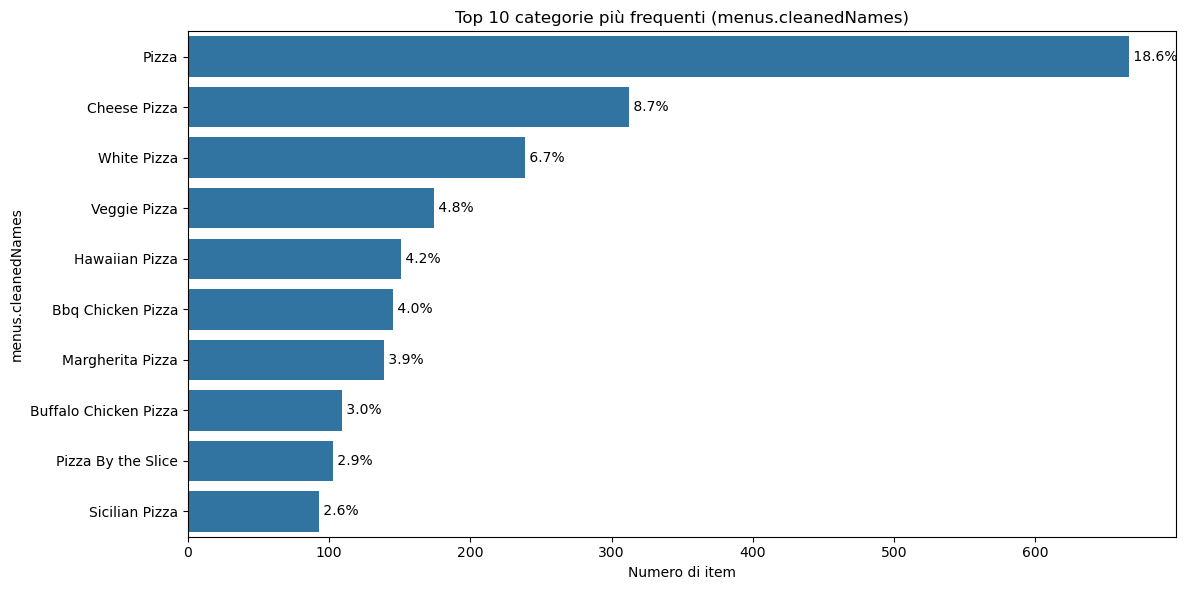

In [32]:
categorical = [
    'city',
    'province',
    'menus.cleanedNames'
]

top_n = 10

for col in categorical:
    if col not in df.columns:
        print(f"Column '{col}' not in DataFrame, skipping.")
        continue

    series = df[col].dropna()

    # Exclude "OTHER" only for menus.cleanedNames
    if col == "menus.cleanedNames":
        series = series[series != "OTHER"]

    counts = series.value_counts().head(top_n)
    total = series.shape[0]
    percentages = (counts / total * 100).round(1)

    plot_df = counts.reset_index()
    plot_df.columns = [col, "count"]
    plot_df["percentage"] = percentages.values

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=plot_df,
        x="count",
        y=col,
        orient="h"
    )

    # aggiungo etichette con percentuale
    for i, row in plot_df.iterrows():
        ax.text(
            row["count"],
            i,
            f" {row['percentage']}%",
            va="center"
        )

    ax.set_xlabel("Numero di item")
    ax.set_ylabel(col)
    ax.set_title(f"Top {top_n} categorie più frequenti ({col})")
    plt.tight_layout()
    plt.show()

From the bar charts:
1. **City distribution**
The distribution of the **city** field is highly concentrated in a few metropolitan areas:

- **New York** dominates overwhelmingly, with more than **600 restaurants**, far ahead of all other cities.
- **Brooklyn** follows as the second most represented area, which is consistent given its population density and number of restaurants.
- Other large cities such as **Los Angeles**, **Buffalo**, **Philadelphia**, **Chicago**, and **Seattle** appear with lower but still notable frequencies.
- The distribution exhibits a **strong long-tail**, where most cities appear only a small number of times.

This indicates that the dataset is **geographically biased** toward large urban centers, particularly the **New York metropolitan area**.

2. **Province distribution**
The **province** (U.S. state code) plot shows an even stronger concentration pattern:

- **NY (New York State)** is by far the most represented, with over **2500 entries**.
- Other highly represented states include **CA**, **PA**, **FL**, **TX**, and **IL**.
- Most other states appear infrequently, forming a long-tail distribution.

This confirms that the dataset is **not uniformly sampled across states**, but instead focuses heavily on a select group of regions.

3. **Cleaned menu names**
The plot of **menus.cleanedNames** shows the frequencies of menu items after cleaning and clustering:

- **Cheese Pizza** is the most common item (if we don't count Pizza, which of course is popular in a pizza restaraunt dataset).
- The distribution demonstrates that the cleaning process successfully merges many noisy, diverse menu names into a smaller number of **high-frequency semantic categories**.

This reveals the **core structure of menu offerings** across restaurants and confirms that the clustering approach produces meaningful aggregated categories.

## Multivariate Analysis

### Numeric vs Numeric

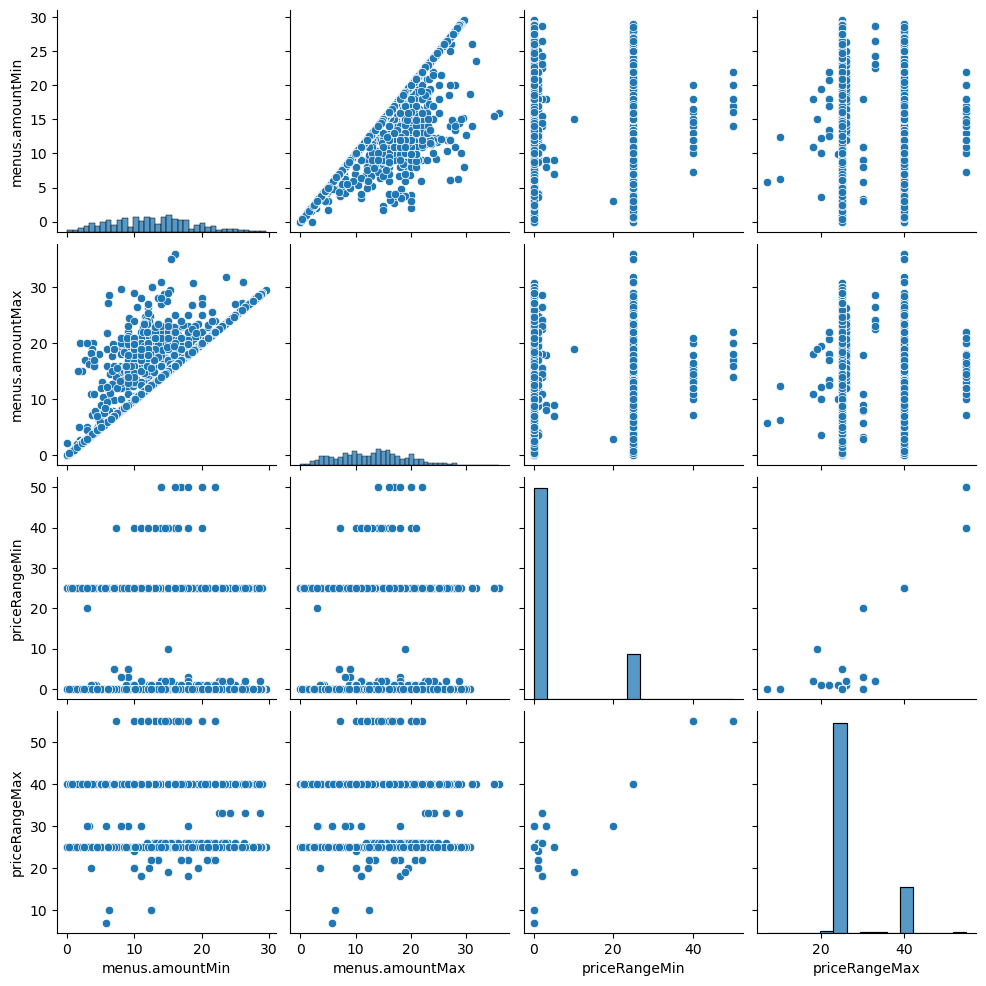

In [33]:
priceCorrelations = [
    'menus.amountMin',
    'menus.amountMax',
    'priceRangeMin',
    'priceRangeMax'
]

geographicCorrelations = [
    'longitude',
    'latitude'
]

sns.pairplot(df[priceCorrelations])
plt.show()

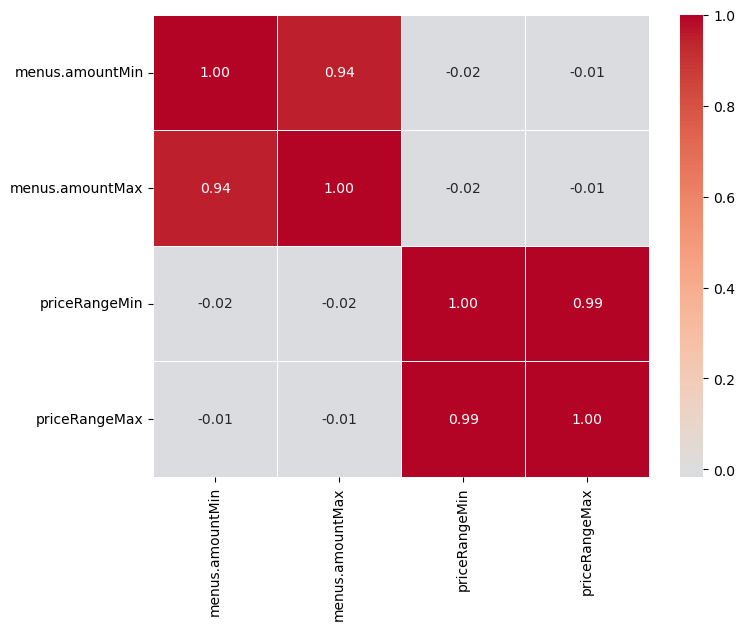

In [34]:
corrMatrix = df[priceCorrelations].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corrMatrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.show()

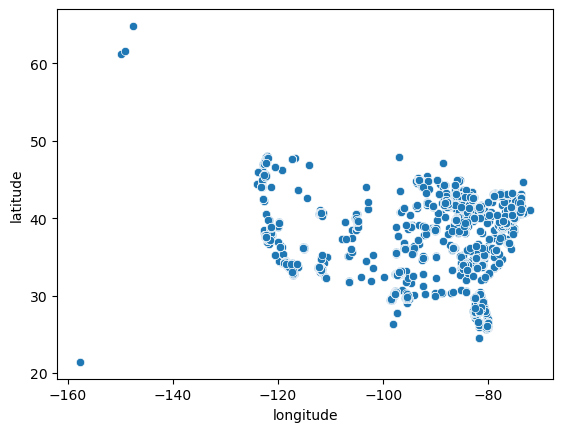

In [35]:
sns.scatterplot(df[geographicCorrelations], x='longitude', y='latitude')
plt.show()

In [36]:
import plotly.express as px
from src.utilities import PALETTE, PIZZA_SCALE, clean_strings

# ------------------------------------------------------------
# Data: count menu items per US state (province)
# ------------------------------------------------------------
# (optional but consistent with your pipeline)
df["province"] = clean_strings(df["province"].astype("string"))

counts = (
    df.dropna(subset=["province"])
      .groupby("province")
      .size()
      .reset_index(name="n_items")
)

# ------------------------------------------------------------
# Choropleth (USA)
# ------------------------------------------------------------
fig = px.choropleth(
    counts,
    locations="province",
    locationmode="USA-states",
    color="n_items",
    scope="usa",
    color_continuous_scale=PIZZA_SCALE,
)

fig.update_layout(
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color=PALETTE["dark_gray"], family="Montserrat, Arial"),
    margin=dict(l=0, r=0, t=0, b=0),
    coloraxis_colorbar=dict(
        title=dict(text="N. item di menu", font=dict(color=PALETTE["dark_gray"])),
        tickfont=dict(color=PALETTE["dark_gray"]),
        outlinewidth=0,
        bgcolor="rgba(0,0,0,0)",
    ),
)

fig.update_geos(
    bgcolor="rgba(0,0,0,0)",
    showland=True,
    landcolor="rgba(0,0,0,0)",
    lakecolor="rgba(0,0,0,0)",
    showlakes=False,
    showocean=False,
    showcountries=False,
    showframe=False,
    showcoastlines=False,
    subunitcolor=PALETTE["dark_gray"],
    subunitwidth=0.4,
)

fig.show()

From the scatter matrix and the correlation heatmaps, only a few relationships clearly emerge.

First, a strong correlation is observed between the price variables (`menus.amountMin` and `menus.amountMax`). This result is expected, since both variables refer to the same menu item and, in most cases, they take identical or very similar values. As such, this correlation does not provide additional analytical insight but rather confirms internal consistency in the pricing fields.

A second visible correlation involves **latitude and longitude**. When plotted against each other, these variables naturally reproduce the geographic shape of the United States. Again, this pattern is expected and reflects spatial structure rather than an intrinsic relationship between the variables themselves.

Beyond these cases, the numeric correlation analysis does not reveal strong linear relationships among the remaining features. This suggests that:
- most numeric variables capture different aspects of the data,
- potential relationships may be **non-linear**, **context-dependent**, or mediated by categorical or geographic factors.

The geographic choropleth map further reinforces this interpretation. While it highlights clear **spatial heterogeneity** in the distribution of menu items across U.S. states (with higher concentrations in more populous or urbanized areas), it does not directly imply causal relationships with pricing or menu complexity. Instead, it suggests that geography may act as a **structuring variable**, motivating downstream analyses that explicitly account for regional effects (e.g. coastal vs inland, state-level aggregation, or spatial segmentation).

Overall, this exploratory correlation analysis indicates that simple pairwise correlations are insufficient to capture the structure of the data, and that richer representations—such as engineered features, categorical groupings, or geographic stratification—are required to uncover more meaningful patterns.

### Numerical vs Categorial
For a multivariate analisys of numerical vs categorial features we will check top N against a numerical value.

#### City

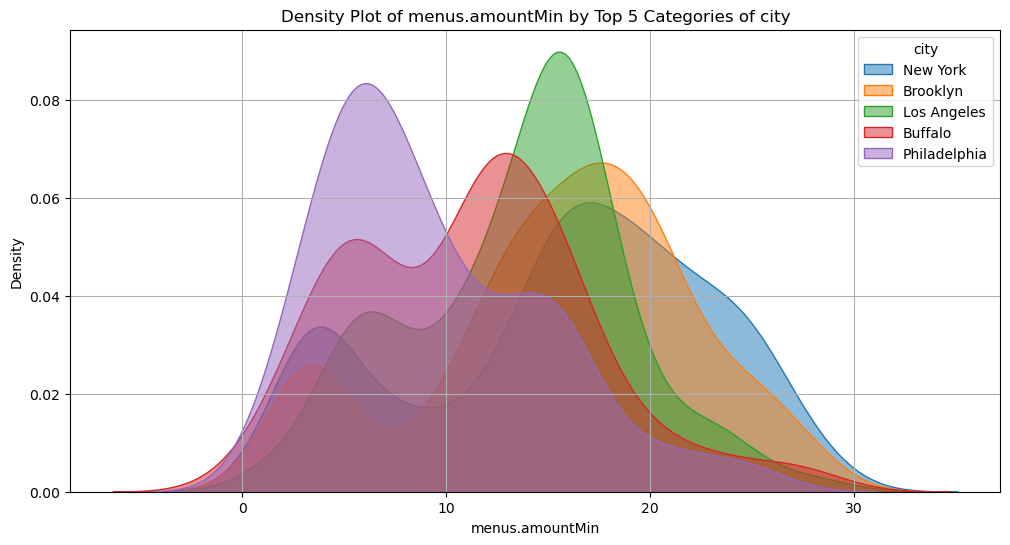

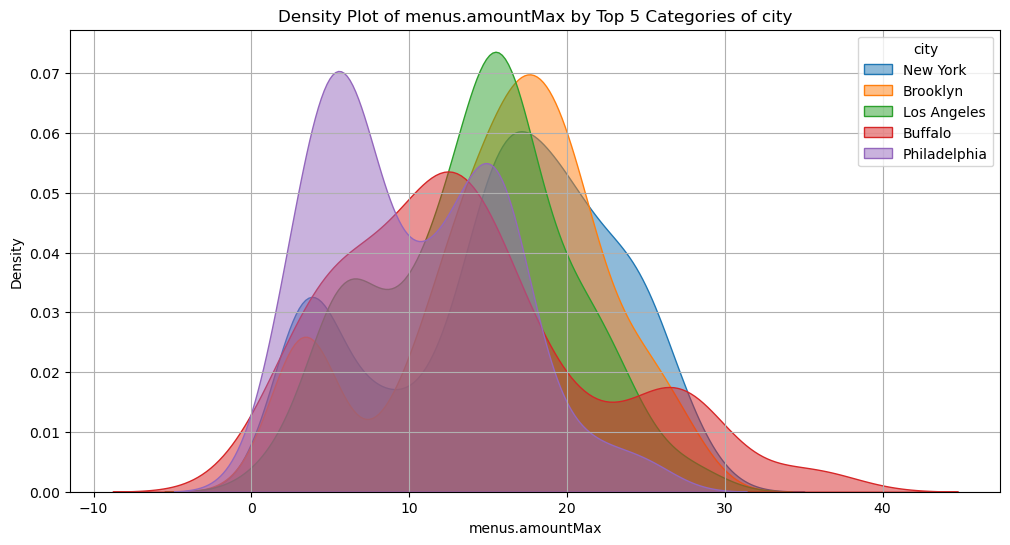

In [37]:
# city report
top_n = 5

from src.utilities import plotCategorialVsNumeric

for price_col in ['menus.amountMin', 'menus.amountMax']:
    plotCategorialVsNumeric(
        df=df,
        categorialCol='city',
        numericCol=price_col,
        top_n=top_n
    )

From the graphs we could say:
1. There is clear **geographic variation** in both minimum and maximum menu amounts. Log Angeles, New York and Brooklyn tend to have higher menu prices where New York showing the widest spred.
2. Philadelphia and Buffalo generally **lower** typycal prices.

But from that we could ask: "Are the cities near to coast more expennsive than internal ones?"

### Coastal vs Internal cities - geographic labeling

In [38]:
import pandas as pd

from src.utilities import haversine_distance_km, is_coastal

# ------------------------------------------------------------
# Reference coastal points (rough US coastline approximation)
# ------------------------------------------------------------
US_COAST_POINTS = [
    # Atlantic coast
    (44.5, -67.5),   # Maine
    (42.3, -70.9),   # Boston
    (40.6, -73.8),   # New York
    (39.3, -74.5),   # Atlantic City
    (36.8, -75.9),   # Virginia Beach
    (34.2, -77.9),   # Wilmington
    (32.1, -81.1),   # Savannah
    (25.8, -80.1),   # Miami

    # Gulf of Mexico
    (30.3, -87.7),   # Pensacola
    (29.0, -90.0),   # Louisiana coast
    (29.3, -94.8),   # Galveston
    (27.8, -97.4),   # Corpus Christi

    # Pacific coast
    (32.7, -117.2),  # San Diego
    (34.0, -118.5),  # Los Angeles
    (36.6, -121.9),  # Monterey
    (37.8, -122.5),  # San Francisco
    (44.0, -124.1),  # Oregon coast
    (47.6, -122.4),  # Seattle

    # Alaska
    (58.3, -134.4),  # Juneau
    (61.2, -149.9),  # Anchorage

    # Hawaii
    (21.3, -157.8),  # Honolulu
    (19.7, -155.1),  # Hilo
]

# ------------------------------------------------------------
# Apply coastal classifier to dataset
# ------------------------------------------------------------
MAX_DIST_KM = 50.0

# NOTE: utilities.is_coastal expects:
# is_coastal(lat, lon, coastline_points, max_distance_km=...)
df["coastal_city"] = df.apply(
    lambda r: is_coastal(
        r["latitude"],
        r["longitude"],
        coastline_points=US_COAST_POINTS,
        max_distance_km=MAX_DIST_KM,
    ),
    axis=1,
).astype(bool)

df["internal_city"] = (~df["coastal_city"]).astype(bool)

# Quick sanity check
df["coastal_city"].value_counts(normalize=True)

coastal_city
False    0.67229
True     0.32771
Name: proportion, dtype: float64

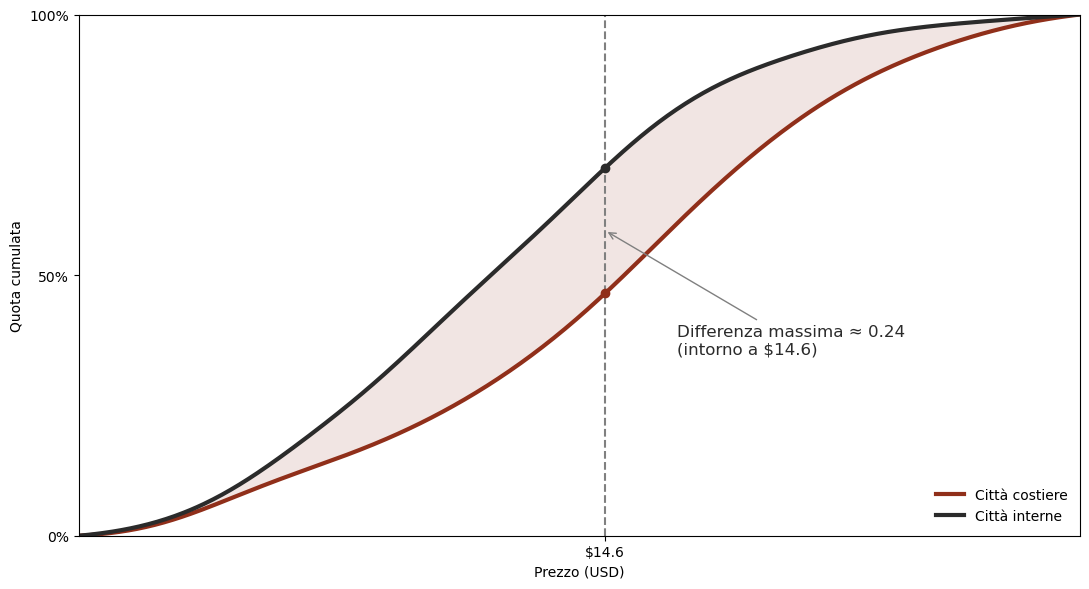

In [39]:
from src.utilities import plot_smooth_cdf

plot_smooth_cdf(
    df,
    "menus.amountMin",
    bw_adjust=1.25,
    transparent_bg=True
)

From the ECDF plots, we can observe that coastal cities tend to have higher menu prices compared to internal cities.

#### Province

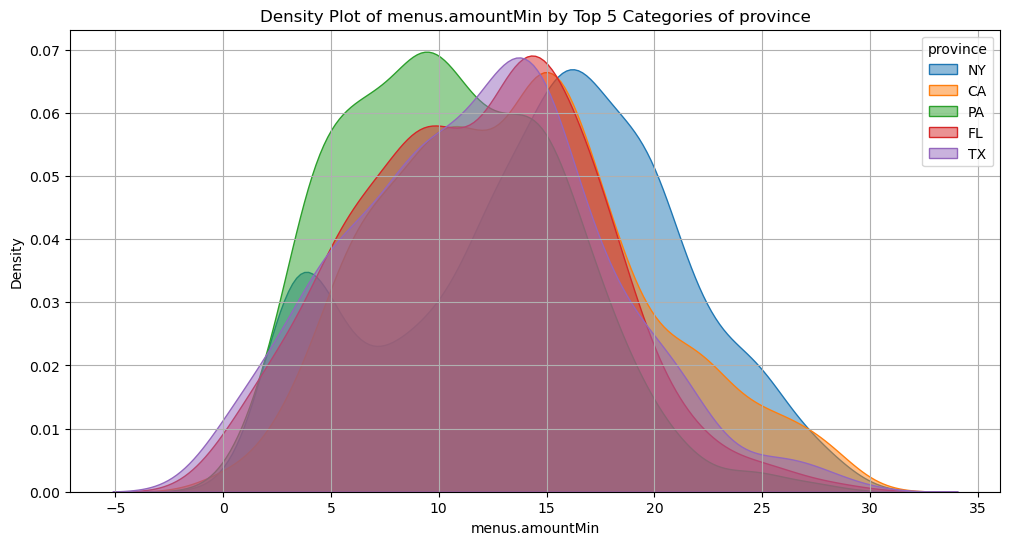

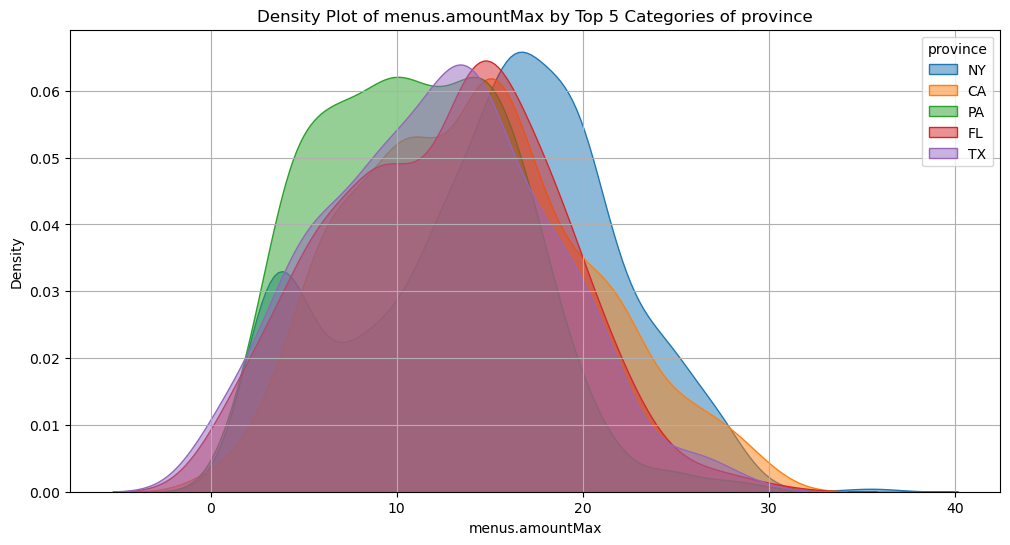

In [40]:
from src.utilities import plotCategorialVsNumeric

for price_col in ['menus.amountMin', 'menus.amountMax']:
    plotCategorialVsNumeric(
        df=df,
        categorialCol='province',
        numericCol=price_col,
        top_n=5
    )

From observations of top 5 province we can say:
1. NY has the highest prices.
2. FL and CA has similar distributions. 
3. PA has the lowest prices.
4. TX is the most wide distribution (here).

#### menus.cleanedNames

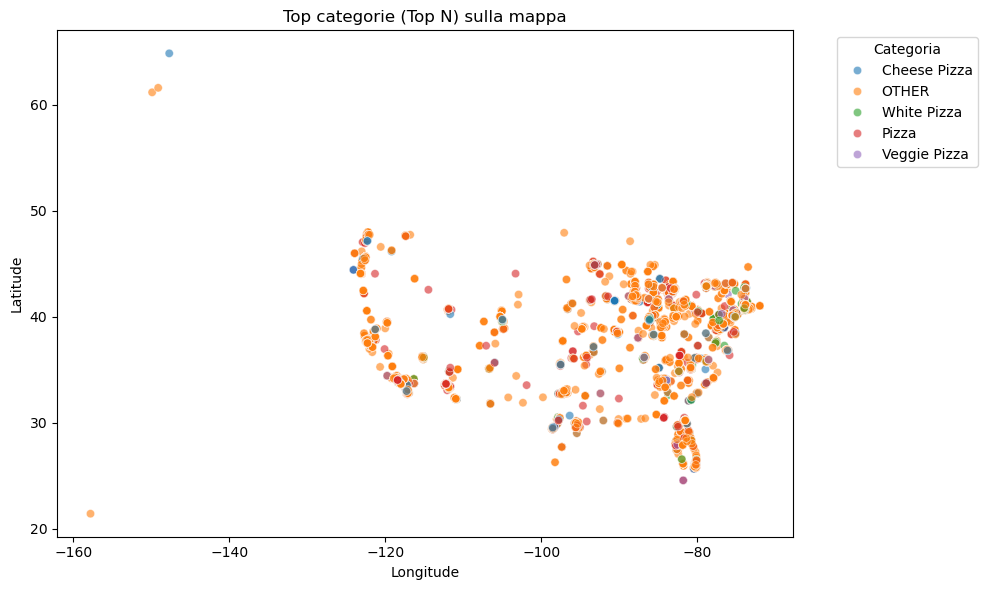

In [41]:
from src.utilities import returnTopN

topN_series = returnTopN(df["menus.cleanedNames"], n=5)
top_categories = topN_series.index  
df_top = df[df["menus.cleanedNames"].isin(top_categories)]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top,
    x="longitude",
    y="latitude",
    hue="menus.cleanedNames",
    alpha=0.6
)

plt.title("Top categorie (Top N) sulla mappa")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

The map shows that the top five pizza categories are spread broadly across the United States, with no clear geographic clustering that separates one type from another. While some regions-particularly the East Coast and parts of the Midwest-display higher concentrations of restaurants, all five categories appear to be evenly mixed throughout these areas.

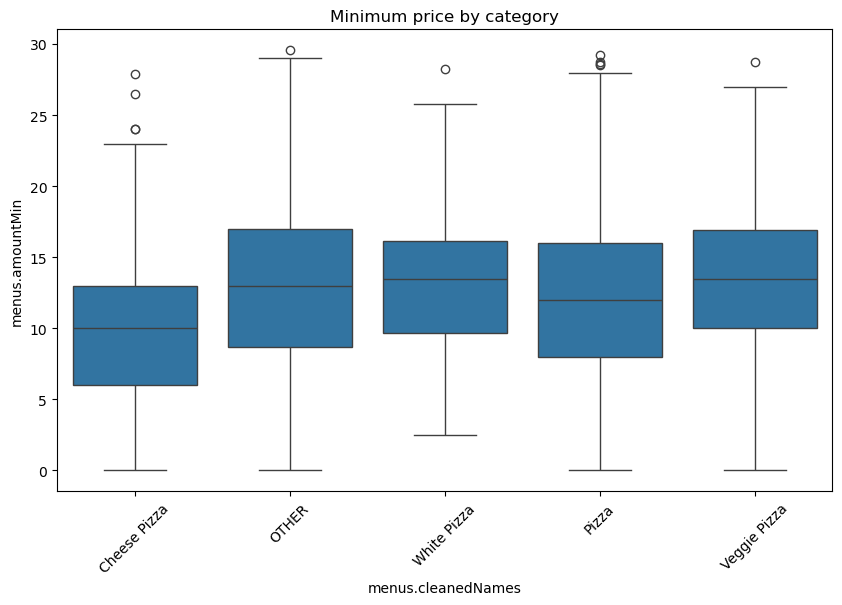

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_top, 
    x="menus.cleanedNames", 
    y="menus.amountMin"
)
plt.xticks(rotation=45)
plt.title("Minimum price by category")
plt.show()

The chart shows that minimum prices are broadly similar across the top pizza categories, with overlapping distributions and comparable medians. Some categories exhibit wider variability and a few low-price outliers, but no category stands out as consistently cheaper or more expensive than the others. The plot also helps explain why cheese pizza is the most common choice: it tends to be priced lower than the other categories, making it a more accessible and widely offered option.

# Part 4: Statistical Inference

## Coastal cities have higher prices than internal cities?

In [43]:
df['menu_price_mean'] = df[['menus.amountMin', 'menus.amountMax']].mean(axis=1)
coastal = df.loc[df['coastal_city'] == True, 'menu_price_mean']
internal = df.loc[df['internal_city'] == True, 'menu_price_mean']

We define:
- **$H_0$** (null): prices mean is equal in both coastal and internal cities.
- **$H_a$** (alternative): coastal cities have, on average, higher prices.

In [44]:
import scipy.stats as stats

SIGNIFICANCE_LEVEL = 0.05

leveneResult = stats.levene(coastal, internal)
equal_var_flag = leveneResult.pvalue > SIGNIFICANCE_LEVEL  # True = varianze ~ uguali

if equal_var_flag:
    print("Variances are NOT significantly different (p-value:", leveneResult.pvalue, ")")
else:
    print("Variances are significantly different (p-value:", leveneResult.pvalue, ")")

testResult = stats.ttest_ind(
    coastal,
    internal,
    equal_var=equal_var_flag,
    alternative="greater"
)

print("T-test result:", testResult.statistic) # type: ignore
print("Significance level:", SIGNIFICANCE_LEVEL)
print(f"P-value:", testResult.pvalue) # type: ignore

if testResult.pvalue < SIGNIFICANCE_LEVEL: # type: ignore
    print("Reject null hypothesis: significant difference in mean menu prices between coastal and internal cities.")
else:
    print("Fail to reject null hypothesis: no significant difference in mean menu prices between coastal and internal cities.")

Variances are significantly different (p-value: 1.7688899500034795e-06 )
T-test result: 22.651915247429354
Significance level: 0.05
P-value: 5.585087873273009e-109
Reject null hypothesis: significant difference in mean menu prices between coastal and internal cities.


Statistical test confirmed our theory: coastal cities have, on average, higher prices than internal ones.

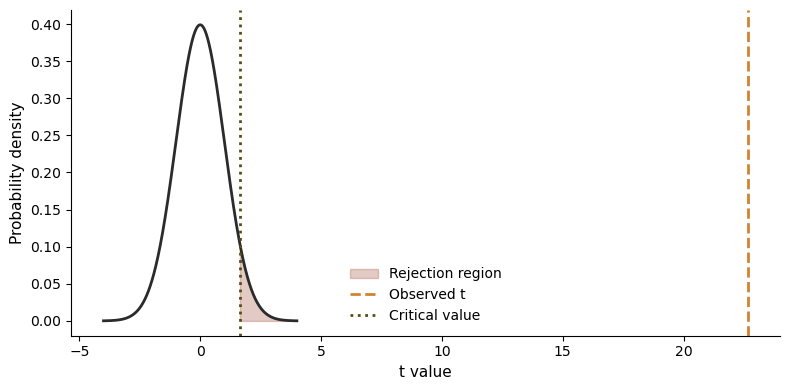

In [45]:
from src.statistical_plot import plot_t_test_distribution

plot_t_test_distribution(
    t_statistic=testResult.statistic,   # ≈ 22
    df=len(coastal) + len(internal) - 2,
    alpha=0.05,
    transparent_background=True,
    title=None,
    xlabel="t value",
    ylabel="Probability density"
)

## Is there a statistical significant difference in the average menu price across the main pizza categories?

We define the top \(n\) pizza categories based on the frequency of `menus.name`.

- **$H_0$ (null):** The mean menu price is the same across the top \(n\) pizza categories.  
  $$
  \mu_1 = \mu_2 = \dots = \mu_n
  $$

- **$H_a$ (alternative):** At least one of the top \(n\) pizza categories has a different mean menu price.  
  $$
  \text{Not all } \mu_i \text{ are equal}
  $$


### What is ANOVA?
The big problem with this (and next) question(s) is that we are trying to classify more than one categorial feature. Scipy does have a solution: ANOVA. 

ANOVA (Analysis of Variance) is a statistical method used to test whether the **means of three or more groups** are equal.  
Instead of comparing groups pairwise with multiple t-tests, one-way ANOVA evaluates a **single global hypothesis**:

- **$H_0$:** All group means are equal  
- **$H_1$:** At least one group mean is different

ANOVA works by comparing two sources of variability:
1. **Within-group variability** – how much observations vary inside each group.
2. **Between-group variability** – how much the group means differ from each other.

If the between-group variability is large relative to within-group variability, the F-statistic becomes large and the p-value becomes small, suggesting that not all means are equal.

---

#### Assumptions of One-Way ANOVA

ANOVA relies on three main assumptions:

1. **Independence of observations**  
   Each observation should be statistically independent from the others.  
   (This is an assumption about study design, not something a statistical test can detect.)

2. **Normality within groups**  
   For each group, the distribution of the response variable should be approximately normal.  
   ANOVA is robust to moderate deviations from normality, especially with large sample sizes.

3. **Homogeneity of variances (homoscedasticity)**  
   All groups should have similar variances.  
   This assumption can be checked using tests such as **Levene’s test**.

---
When ANOVA assumptions will be violated, we will use **bootstraping**.

In [46]:
from scipy.stats import f_oneway 
from src.utilities import check_anova_assumptions

n = 5
topN = returnTopN(df["menus.cleanedNames"], n)
categories = topN.index.tolist()

groupedData = [df.loc[df["menus.cleanedNames"] == cat, "menu_price_mean"]
          for cat in categories]

assumption_results = check_anova_assumptions(groupedData, labels=categories)

=== Group sizes ===
OTHER: n = 5600
Pizza: n = 666
Cheese Pizza: n = 312
White Pizza: n = 239
Veggie Pizza: n = 174

=== Levene test for equality of variances ===
Statistic = 14.382, p-value = 1.071e-11

=== Per-group shape and normality (D'Agostino-Pearson) ===
OTHER: std = 5.923, skew = 0.139, excess kurtosis = -0.453, normality p = 4.046e-20
Pizza: std = 6.072, skew = 0.275, excess kurtosis = -0.427, normality p = 3.047e-04
Cheese Pizza: std = 4.876, skew = 0.701, excess kurtosis = 0.565, normality p = 3.263e-06
White Pizza: std = 4.922, skew = 0.048, excess kurtosis = -0.208, normality p = 7.873e-01
Veggie Pizza: std = 4.891, skew = 0.462, excess kurtosis = 0.637, normality p = 1.401e-02

=== Variance ratio (max variance - min variance) ===
Variance ratio = 1.551


#### Assumption checks for the ANOVA on pizza categories

Before interpreting the one-way ANOVA on mean menu prices across the top 5 pizza categories, we checked its main assumptions.

- **Group sizes.** All categories have large sample sizes (from 409 up to 1,487 observations), which makes the ANOVA relatively robust to moderate deviations from normality.
- **Homogeneity of variances.** A Levene test returns a very small p-value (p ≈ $4.1 \cdot 10^{-11}$), so the null hypothesis of equal variances is formally rejected. However, the variance ratio (maximum variance divided by minimum variance) is about 1.68, indicating that the differences in group variances are moderate rather than extreme.
- **Normality within groups.** Skewness and excess kurtosis are moderate for all groups. D’Agostino–Pearson normality tests are significant for some categories (especially Cheese Pizza, likely due to the large sample size), indicating that the distributions are not perfectly normal. Nevertheless, there are no severe departures from normality.

In summary, the ANOVA assumptions are not perfectly met: variances are not exactly homogeneous and normality is only approximate. Given the large sample sizes and the moderate magnitude of these deviations, we still report the classical one-way ANOVA results, but we complement them with boostrapping.

In [47]:
anova_result = f_oneway(*groupedData)

print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

if anova_result.pvalue < SIGNIFICANCE_LEVEL:
    print("Reject null hypothesis: significant difference in average menu prices across pizza categories.")
else:
    print("Fail to reject null hypothesis: no significant difference in average menu prices across pizza categories.")

F-statistic: 22.480700915728526
p-value: 1.7991801423685935e-18
Reject null hypothesis: significant difference in average menu prices across pizza categories.


--- 95% Bootstrap Confidence Intervals for mean menu_price_mean ---
OTHER                      mean_boot =  13.22   CI 95% = ( 13.06,  13.37)
Pizza                      mean_boot =  12.63   CI 95% = ( 12.16,  13.09)
Cheese Pizza               mean_boot =  10.20   CI 95% = (  9.67,  10.74)
White Pizza                mean_boot =  13.67   CI 95% = ( 13.05,  14.29)
Veggie Pizza               mean_boot =  14.04   CI 95% = ( 13.32,  14.79)


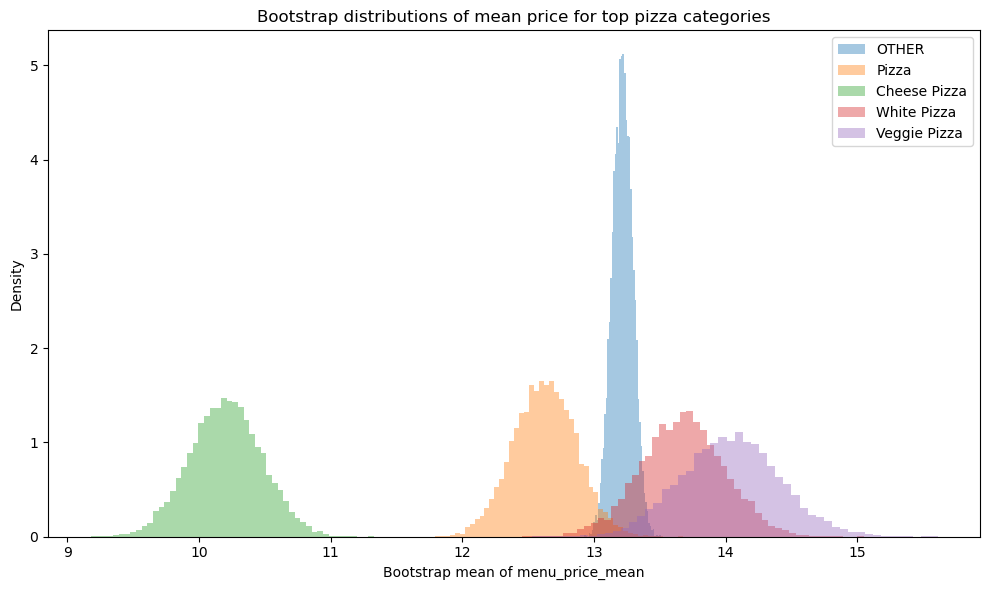

In [48]:
from sklearn.utils import resample
import numpy as np

n_boot = 10000 
confidence = 95

bootstrap_means = {cat: [] for cat in categories}

for i in range(n_boot):
    for cat in categories:
        data = df.loc[df["menus.cleanedNames"] == cat, "menu_price_mean"]
        boot_sample = resample(data, replace=True, n_samples=len(data)) # type: ignore
        boot_mean = np.mean(boot_sample) # type: ignore
        bootstrap_means[cat].append(boot_mean)

print(f"--- {confidence}% Bootstrap Confidence Intervals for mean menu_price_mean ---")
for cat in categories:
    means = np.array(bootstrap_means[cat])
    lower = np.percentile(means, (100 - confidence) / 2)
    upper = np.percentile(means, 100 - (100 - confidence) / 2)
    mean_boot = means.mean()
    print(f"{cat:25s}  mean_boot = {mean_boot:6.2f}   CI {confidence}% = ({lower:6.2f}, {upper:6.2f})")


plt.figure(figsize=(10, 6))

for cat, means in bootstrap_means.items():
    means = np.array(means)
    plt.hist(
        means,
        bins=50,
        alpha=0.4,
        density=True,
        label=cat
    )

plt.xlabel("Bootstrap mean of menu_price_mean")
plt.ylabel("Density")
plt.title("Bootstrap distributions of mean price for top pizza categories")
plt.legend()
plt.tight_layout()
plt.show()

The bootstrap confidence intervals and the distributions of the bootstrap means clearly show that average prices differ across the main pizza categories. Cheese Pizza has the lowest mean price (around \$10.7), with a 95% CI that does not overlap with any other category, indicating it is clearly cheaper. Greek Pizza and Buffalo Chicken Pizza have the highest mean prices (around \$15.2 and \$14.4 respectively), while Pizza Steak and White Pizza lie in between. The bootstrap distributions are narrow and well separated, especially between Cheese Pizza and the other categories, which confirms and visually strengthens the ANOVA result that mean menu prices are not equal across these pizza categories.

The statistical test rejects the null hypothesis: the average of the prices for the top N categories are different.

## Do the business-level price ranges (priceRangeMin/Max) align with actual menu item prices? How consistent is that alignment by state?

For this questions, there are more than one statistical tests to do.

In [49]:
df["menu_price"] = df[["menus.amountMin", "menus.amountMax"]].mean(axis=1)
df["business_price_mean"] = df[["priceRangeMin", "priceRangeMax"]].mean(axis=1) 
df["price_alignment_diff"] = df["menu_price"] - df["business_price_mean"]

# updating dfUniqueID
dfUniqueID = df.drop_duplicates(subset=['id']).reset_index(drop=True)

### Do business-level price ranges align with actual menu item prices?

We need to find:
$$
d = menu\_price - business\_menu\_price
$$

where
$$
menu\_price = \frac{menus.amountMin + menus.amountMax}{2}
$$
$$
business\_menu\_price = \frac{priceRangeMin + priceRangeMax}{2}
$$

In [50]:
d = dfUniqueID["price_alignment_diff"].dropna()

ttest_global = stats.ttest_1samp(d, popmean=0, alternative="two-sided")

print("=== One-sample t-test on price_alignment_diff ===")
print(f"Sample size: {len(d)}")
print(f"Mean difference (menu - business): {d.mean():.3f}")
print(f"t-statistic: {ttest_global.statistic:.3f}") # type: ignore
print(f"p-value: {ttest_global.pvalue}") # type: ignore

if ttest_global.pvalue < SIGNIFICANCE_LEVEL: # type: ignore
    print("Reject H0: business-level price ranges are not perfectly aligned with menu prices.")
else:
    print("Fail to reject H0: no significant evidence of a systematic misalignment between business ranges and menu prices.")

=== One-sample t-test on price_alignment_diff ===
Sample size: 2231
Mean difference (menu - business): -4.617
t-statistic: -22.110
p-value: 4.149898844076599e-98
Reject H0: business-level price ranges are not perfectly aligned with menu prices.


### How consistent is that alignment by state?

In [51]:
# ANOVA assumption check
group_data = []
province_labels = []

min_n = 30 # minimum number of observations per province

for province, group in df.groupby("province"):
    diffs = group["price_alignment_diff"].dropna()
    if len(diffs) >= min_n:
        group_data.append(diffs)
        province_labels.append(province)

print("Province included:", province_labels)

results_province = check_anova_assumptions(
    groups=group_data,
    labels=province_labels
)

Province included: ['AR', 'AZ', 'CA', 'CO', 'FL', 'GA', 'IA', 'IL', 'IN', 'KS', 'KY', 'MD', 'MI', 'MN', 'MO', 'NC', 'NM', 'NV', 'NY', 'OH', 'OR', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI']
=== Group sizes ===
AR: n = 38
AZ: n = 270
CA: n = 1263
CO: n = 136
FL: n = 533
GA: n = 205
IA: n = 51
IL: n = 337
IN: n = 202
KS: n = 36
KY: n = 65
MD: n = 110
MI: n = 345
MN: n = 92
MO: n = 91
NC: n = 242
NM: n = 43
NV: n = 137
NY: n = 2433
OH: n = 292
OR: n = 114
PA: n = 753
SC: n = 76
TN: n = 58
TX: n = 444
UT: n = 101
VA: n = 222
WA: n = 237
WI: n = 119

=== Levene test for equality of variances ===
Statistic = 14.043, p-value = 1.764e-64

=== Per-group shape and normality (D'Agostino-Pearson) ===
AR: std = 8.906, skew = 0.191, excess kurtosis = -1.091, normality p = 5.845e-02
AZ: std = 12.252, skew = -0.381, excess kurtosis = -1.000, normality p = 5.874e-13
CA: std = 11.404, skew = -0.228, excess kurtosis = -1.009, normality p = 1.593e-65
CO: std = 9.511, skew = -1.227, excess kurtosis = 0

For the ANOVA on price_alignment_diff by province, the assumption checks indicate that the classical one-way ANOVA is not very reliable in this setting.

- The Levene test strongly rejects the null of equal variances (p ≈ $7.0 \cdot 10^-61$), and the variance ratio (max variance / min variance) is about 4.15, indicating substantial heteroscedasticity across provinces.
- Several provinces show marked deviations from normality (strong skewness and excess kurtosis, with very small normality-test p-values), and group sizes are highly unbalanced (from 40 observations up to more than 2,500).

Because both the equal-variance and normality assumptions are clearly violated and group sizes are very unequal, the classical ANOVA F-test may give misleading p-values. We therefore complement (and essentially replace) it with a bootstrap test.


In [52]:
anova_result = stats.f_oneway(*group_data)

print("\n=== One-way ANOVA on alignment_diff by province ===")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"p-value: {anova_result.pvalue}")

if anova_result.pvalue < SIGNIFICANCE_LEVEL:
    print("Conclusion: Reject H0.")
    print("→ Alignment between menu prices and business price ranges differs significantly across provinces.")
else:
    print("Conclusion: Fail to reject H0.")
    print("→ No significant evidence that alignment differs across provinces.")


=== One-way ANOVA on alignment_diff by province ===
F-statistic: 20.931
p-value: 4.4924111398988236e-102
Conclusion: Reject H0.
→ Alignment between menu prices and business price ranges differs significantly across provinces.


--- 95% Bootstrap Confidence Intervals for mean(price_alignment_diff) by province ---
AR   mean_boot = -11.55   CI 95% = (-14.25,  -8.72)
AZ   mean_boot =  -7.22   CI 95% = ( -8.69,  -5.79)
CA   mean_boot =  -5.40   CI 95% = ( -6.03,  -4.78)
CO   mean_boot =  -3.84   CI 95% = ( -5.38,  -2.26)
FL   mean_boot =  -4.22   CI 95% = ( -5.06,  -3.40)
GA   mean_boot =  -6.45   CI 95% = ( -7.89,  -5.03)
IA   mean_boot =  -3.72   CI 95% = ( -6.45,  -1.13)
IL   mean_boot =  -3.17   CI 95% = ( -4.18,  -2.21)
IN   mean_boot =  -5.57   CI 95% = ( -6.90,  -4.29)
KS   mean_boot =  -3.18   CI 95% = ( -5.15,  -1.21)
KY   mean_boot =  -5.54   CI 95% = ( -7.72,  -3.44)
MD   mean_boot =  -6.25   CI 95% = ( -8.19,  -4.33)
MI   mean_boot =  -5.12   CI 95% = ( -5.99,  -4.28)
MN   mean_boot =  -2.52   CI 95% = ( -4.39,  -0.82)
MO   mean_boot =  -6.25   CI 95% = ( -8.03,  -4.52)
NC   mean_boot =  -5.54   CI 95% = ( -6.82,  -4.29)
NM   mean_boot =  -2.78   CI 95% = ( -4.71,  -1.11)
NV   mean_boot =   2.24   CI 9

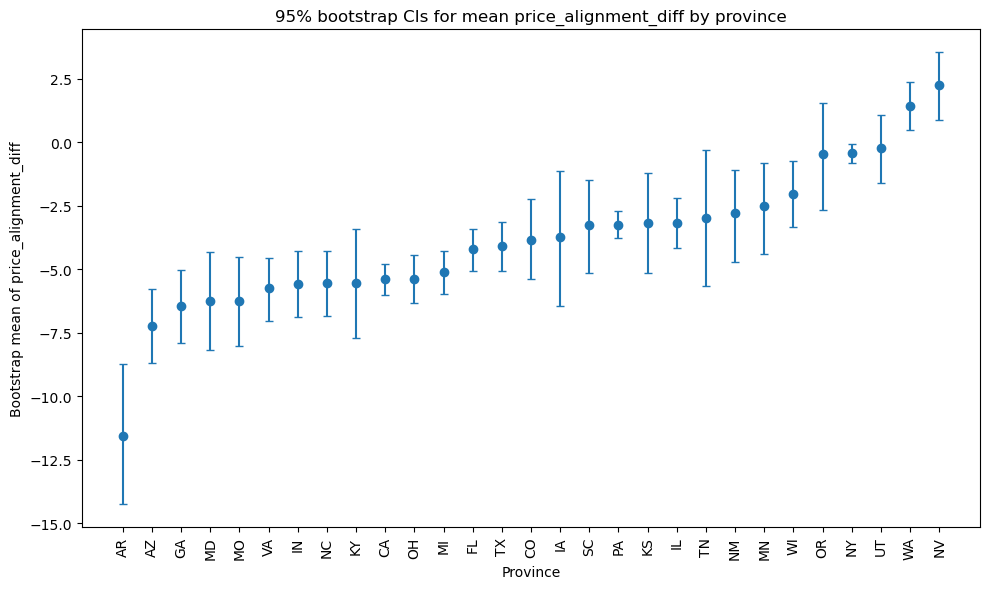

In [53]:
n_boot = 5000
confidence = 95

bootstrap_means_prov = {prov: [] for prov in province_labels}

for i in range(n_boot):
    for prov in province_labels:
        data = df.loc[df["province"] == prov, "price_alignment_diff"] 
        boot_sample = resample(data, replace=True, n_samples=len(data)) # type: ignore
        bootstrap_means_prov[prov].append(np.mean(boot_sample))  # type: ignore

print(f"--- {confidence}% Bootstrap Confidence Intervals for mean(price_alignment_diff) by province ---")
prov_stats = {}
for prov in province_labels:
    means = np.array(bootstrap_means_prov[prov])
    lower = np.percentile(means, (100 - confidence) / 2)
    upper = np.percentile(means, 100 - (100 - confidence) / 2)
    mean_boot = means.mean()
    prov_stats[prov] = (mean_boot, lower, upper)
    print(f"{prov:3s}  mean_boot = {mean_boot:6.2f}   CI {confidence}% = ({lower:6.2f}, {upper:6.2f})")

sorted_provs = sorted(province_labels, key=lambda p: prov_stats[p][0])

means = [prov_stats[p][0] for p in sorted_provs]
lowers = [prov_stats[p][1] for p in sorted_provs]
uppers = [prov_stats[p][2] for p in sorted_provs]

x = np.arange(len(sorted_provs))
yerr = [np.array(means) - np.array(lowers), np.array(uppers) - np.array(means)]

plt.figure(figsize=(10, 6))
plt.errorbar(x, means, yerr=yerr, fmt="o", capsize=3)
plt.xticks(x, sorted_provs, rotation=90)
plt.xlabel("Province")
plt.ylabel("Bootstrap mean of price_alignment_diff")
plt.title(f"{confidence}% bootstrap CIs for mean price_alignment_diff by province")
plt.tight_layout()
plt.show()


The classical one-way ANOVA on price_alignment_diff by province yielded a highly significant p-value, suggesting that the alignment between menu prices and business price ranges is not the same across provinces. However, the assumption checks show that ANOVA is not very reliable here: the Levene test strongly rejects homogeneity of variances (p ≈ $7.0 \cdot 10^{-61}$), the variance ratio is about 4.15, many provinces display clear non-normality, and group sizes are very unbalanced.

The bootstrap confidence intervals for the mean price_alignment_diff provide a more robust picture. In most provinces the 95% CI is entirely below zero, indicating that menu prices tend to be systematically lower than the business-level ranges (e.g., AR around −11 dollars, AZ and GA around −6–7 dollars). A few provinces are close to alignment (NY, WI, OR, UT), and some even show positive differences (WA and especially NV, where the CI lies above zero). These bootstrap results confirm the qualitative conclusion of the ANOVA-that alignment varies substantially by province—while also quantifying which states have the strongest underpricing or overpricing relative to their declared price ranges.

## Is pizza category consumption distributed differently across provinces, or does it remain consistent regardless of the state?

We define

- **$H_0$** (null hypothesis): The distribution of pizza categories is the same across all provinces; pizza category consumption is independent of the province.

- **$H_a$** (alternative hypothesis): The distribution of pizza categories differs across provinces; pizza category consumption depends on the province.

In [54]:
contingency_table = pd.crosstab(df["province"], df["menus.cleanedNames"])

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

if p < SIGNIFICANCE_LEVEL: # type: ignore
    print("Reject H0: pizza categories distribution depends on the province.")
else:
    print("Fail to reject H0: no evidence that pizza category distribution varies by province.")

Chi-square statistic: 4077.572378736741
Degrees of freedom: 1722
p-value: 6.6363523413057074e-192
Reject H0: pizza categories distribution depends on the province.


In [55]:
n = contingency_table.values.sum()
min_dim = min(contingency_table.shape) - 1

cramers_v = np.sqrt(chi2 / (n * min_dim))

print("Cramér's V (Effect Size)")
print(f"Cramér's V: {cramers_v:.4f}")

Cramér's V (Effect Size)
Cramér's V: 0.1040


Pizza category distributions vary significantly across provinces, although the strength of the association is weak (Cramér’s $V = 0.21$).

# Part 5: Statistical modelling and Machine learning 

## Statistical modelling

In this section, we focus on **statistical modelling** with the goal of *explaining* the relationships observed in the data, rather than maximizing predictive performance.  
While machine learning models are well suited for high-dimensional prediction tasks, statistical models allow us to identify **interpretable associations** between variables and to reason about their magnitude, direction, and statistical significance.

In particular, we adopt a regression-based approach to study how structural characteristics of restaurants—such as menu composition and geographic context—are associated with menu prices.  
To ensure interpretability and robustness, we rely on **parsimonious linear models** and apply appropriate transformations to the target variable when needed.

In [56]:
dfm = df.copy()
dfm = dfm.rename(columns=lambda c: c.replace(".", "_")).copy()

dfm = dfm[dfm["menu_price"].notna() & (dfm["menu_price"] > 0)].copy()
dfm["log_price"] = np.log(dfm["menu_price"])

### Linear model for menu prices

To further investigate the relationship between menu characteristics and prices, we estimate a **linear model for menu prices in levels** using a parsimonious specification that emphasizes interpretability. Rather than relying on a broad set of covariates, the analysis focuses on a single, economically meaningful explanatory variable: `menu_complexity`, which summarizes the structure and richness of the menu.

The model is estimated using **quantile regression at the median**, a method that is particularly well suited to pricing data characterized by discrete values and heterogeneous dispersion. Unlike ordinary least squares, quantile regression does not impose distributional assumptions on the error term and allows us to characterize the conditional median of menu prices as a function of menu complexity.

This specification provides a direct and robust representation of the underlying pricing rule in absolute terms, capturing how prices increase in fixed increments as menu complexity grows. It also facilitates a transparent visualization of the estimated relationship through a single regression line, which can be directly compared with the observed pricing patterns in the data.

Unlike ordinary least squares (OLS), which estimates the conditional mean of menu prices by solving
$$
\min_{\beta} \sum_{i} \left(y_i - x_i^\top \beta\right)^2,
$$
quantile regression focuses on a conditional quantile of the price distribution. In particular, median quantile regression ($\tau = 0.5$) estimates the coefficients by solving
$$
\min_{\beta} \sum_{i} \rho_{0.5}\!\left(y_i - x_i^\top \beta\right),
$$
where $\rho_{\tau}(u) = u(\tau - \mathbb{I}\{u < 0\})$ is the asymmetric absolute loss function. This approach is more robust to discrete pricing, heterogeneous dispersion, and extreme values, allowing the model to capture the typical pricing rule rather than average effects driven by a small number of high-priced menus.

Importantly, the quantile regression objective does not rely on a Euclidean notion of distance between observations. Instead, it minimizes the sum of absolute vertical deviations between observed prices and their predicted conditional median. This focus allows the model to capture the typical pricing rule associated with a given level of menu complexity, rather than average effects driven by extreme or irregular price values, making the specification both robust and economically interpretable.

In [57]:
from src.utilities import safe_sum
import statsmodels.formula.api as smf

# -----------------------------
# 1) Basic cleaning / typing
# -----------------------------
dfm["menu_price"] = pd.to_numeric(dfm["menu_price"], errors="coerce")
dfm = dfm[dfm["menu_price"].notna()].copy()

# coastal_city -> 0/1 (esplicito, evita sorprese con bool)
dfm["coastal_city"] = dfm["coastal_city"].astype(int)

# -----------------------------
# 2) Interpretable menu aggregations (safe)
# -----------------------------
menu_cols = [c for c in dfm.columns if c.startswith("menu_")]

diet_cols = [c for c in menu_cols if "diet_" in c]
size_cols = [c for c in menu_cols if "size_" in c]

dfm["menu_complexity"] = safe_sum(dfm, menu_cols)
dfm["menu_special_diets"] = safe_sum(dfm, diet_cols)
dfm["menu_sizes_count"] = safe_sum(dfm, size_cols)

# Optional: price vs city median (attenzione: può essere "leaky" se usato per predire menu_price)
if "city" in dfm.columns:
    city_median = dfm.groupby("city")["menu_price"].transform("median")
    dfm["price_vs_city_median"] = (dfm["menu_price"] / city_median).replace([np.inf, -np.inf], np.nan)
else:
    dfm["price_vs_city_median"] = np.nan

# Robust standard errors (HC3) — questo è il "robusto" corretto in OLS
ols_model = smf.quantreg(
    "menu_price ~  menu_complexity",
    data=dfm
).fit(q=0.5)

print(ols_model.summary())
print("Mean Squared Error:", ols_model.mse_resid)

                         QuantReg Regression Results                          
Dep. Variable:             menu_price   Pseudo R-squared:               0.9636
Model:                       QuantReg   Bandwidth:                     0.08709
Method:                 Least Squares   Sparsity:                       0.1644
Date:                Wed, 14 Jan 2026   No. Observations:                 9149
Time:                        18:33:44   Df Residuals:                     9147
                                        Df Model:                            1
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6.569e-07      0.002      0.000      1.000      -0.004       0.004
menu_complexity     0.5000   7.19e-05   6955.102      0.000       0.500       0.500
Mean Squared Error: 0.12348244119744432


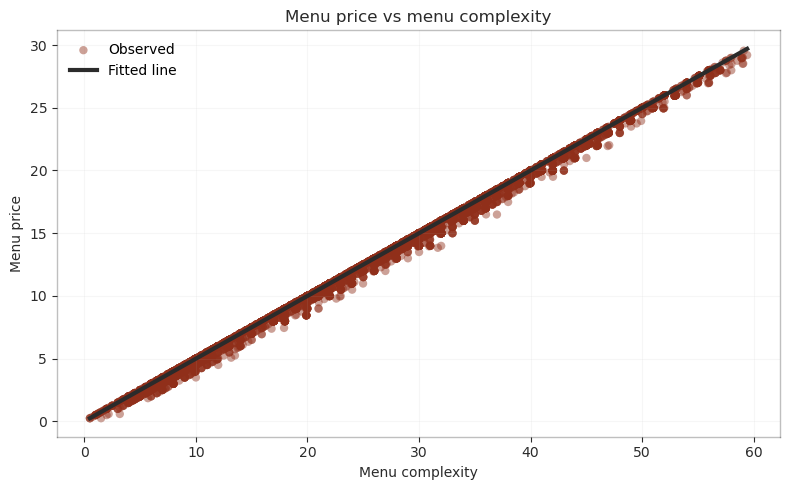

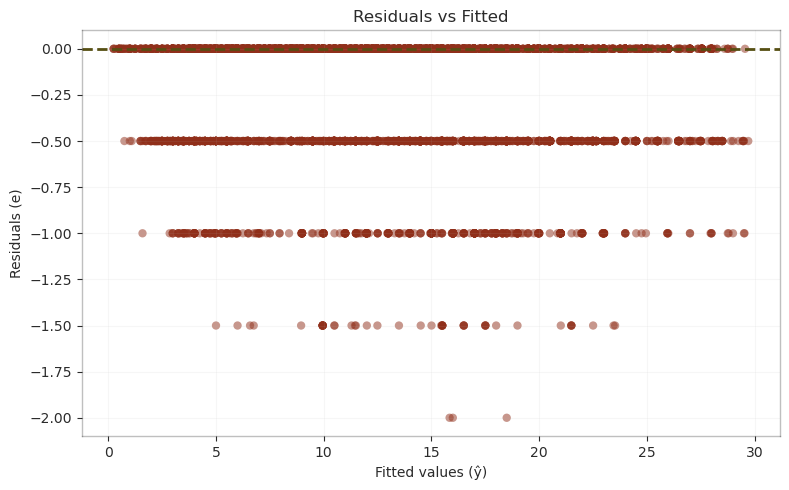

In [58]:
from src.utilities import PALETTE, style_axes

# ------------------------------------------------------------
# Toggle: transparent background
# ------------------------------------------------------------
transparent_bg = True  # True = transparent, False = light_bg

# =============================
# 1) Scatter + regression line
# =============================
x = dfm["menu_complexity"]
y = dfm["menu_price"]

x_line = np.linspace(x.min(), x.max(), 200)
y_line = (
    ols_model.params["Intercept"]
    + ols_model.params["menu_complexity"] * x_line
)

fig1, ax1 = plt.subplots(figsize=(8, 5))

ax1.scatter(
    x, y,
    alpha=0.45,
    color=PALETTE["red"],
    edgecolor="none",
    label="Observed",
)
ax1.plot(
    x_line, y_line,
    linewidth=3,
    color=PALETTE["dark_gray"],
    label="Fitted line",
)

ax1.set_title("Menu price vs menu complexity")
ax1.set_xlabel("Menu complexity")
ax1.set_ylabel("Menu price")
ax1.legend(frameon=False)

style_axes(ax1, transparent_bg=transparent_bg)
fig1.tight_layout()
plt.show()

# =============================
# 2) Residuals vs Fitted
# =============================
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

fig2, ax2 = plt.subplots(figsize=(8, 5))

ax2.scatter(
    fitted_vals,
    residuals,
    alpha=0.5,
    color=PALETTE["red"],
    edgecolor="none",
)

# zero reference line (stat reference)
ax2.axhline(
    0,
    linestyle="--",
    linewidth=2,
    color=PALETTE["green"],
)

ax2.set_title("Residuals vs Fitted")
ax2.set_xlabel("Fitted values (ŷ)")
ax2.set_ylabel("Residuals (e)")

style_axes(ax2, transparent_bg=transparent_bg)
fig2.tight_layout()
plt.show()

### Results and interpretation

The estimated linear model explains a very large share of the variability in menu prices, with an R-squared value close to one. This strong goodness of fit is entirely driven by the variable `menu_complexity`, which emerges as the key determinant of pricing in the dataset.

The coefficient associated with `menu_complexity` is large, precisely estimated, and highly statistically significant. The estimate indicates that each additional unit of menu complexity is associated with an increase of approximately **0.5 monetary units** in the menu price. This finding suggests the presence of a clear and systematic pricing rule, whereby prices increase in nearly fixed increments as the number of available options, sizes, or menu features expands.

The exclusion of the geographic indicator (`costal_city`) reflects the fact that, once menu complexity is accounted for, location does not provide additional explanatory power. Observed price differences across cities therefore appear to be primarily driven by differences in menu composition rather than by a direct geographic pricing premium.

Despite the excellent fit, the results should be interpreted with some caution. Modeling prices in levels makes the specification sensitive to scale and to discrete pricing practices, and the very high R-squared does not necessarily imply a universally superior explanatory model. Rather, it reflects the strong and almost mechanical relationship between menu complexity and prices when both variables are expressed in absolute terms

### Feature-family dynamics across menu complexity

To better understand how menu composition evolves as overall menu complexity increases, we adopt a **feature-family aggregation approach**. Rather than analyzing individual one-hot variables in isolation, we group related binary indicators (e.g. sizes, diets, crust types) into coherent *families* and compute, for each value of `menu_complexity`, the **mean family intensity**—defined as the average share of active one-hot flags within that family.

This transformation yields a low-dimensional and interpretable representation of menu composition, allowing us to track how different dimensions of the menu expand or contract as complexity grows. We then study **marginal changes** by computing first differences across consecutive complexity levels, which capture how menu composition adjusts when moving from complexity \(k\) to \(k+1\).

Top families by mean absolute delta:


,mean_abs_delta
size,0.011472
diet,0.009663
topping,0.006566


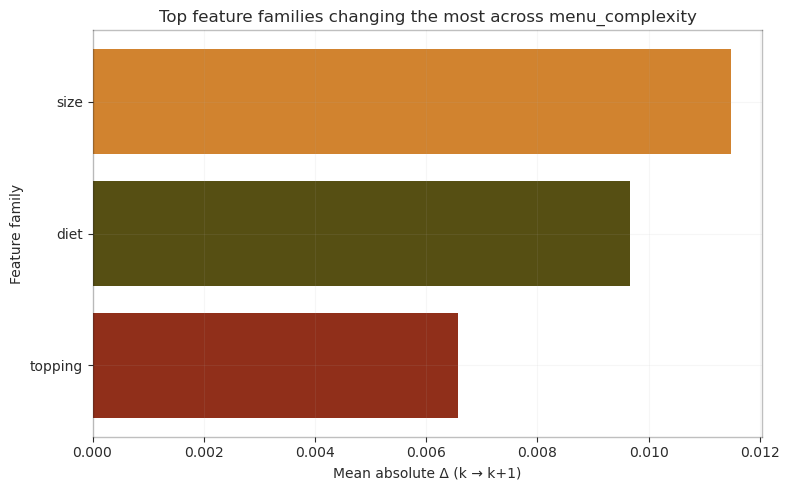

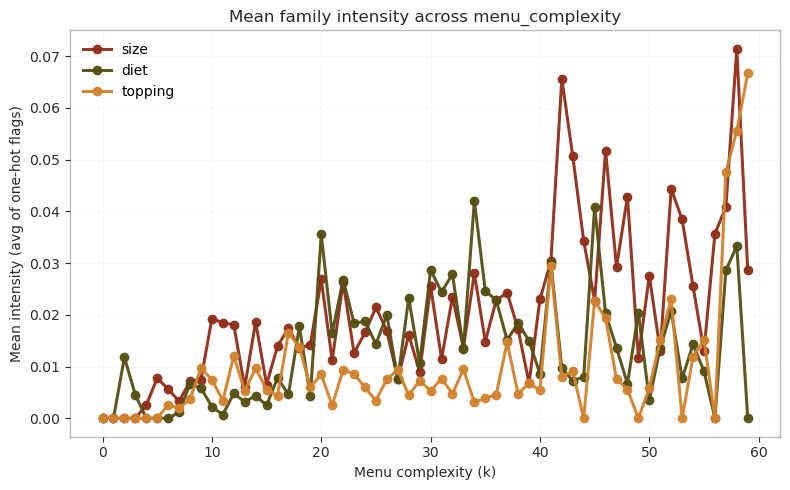

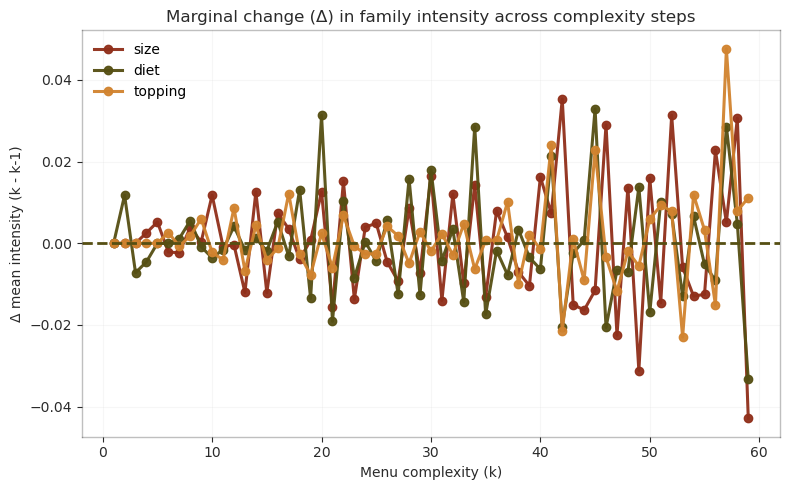

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utilities import PALETTE, style_axes

# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
transparent_bg = True
TOP_H = 3  # how many families to highlight (use 1 if you want only the top one)

# ------------------------------------------------------------
# 0) Build families of one-hot columns
# ------------------------------------------------------------
menu_cols = [c for c in dfm.columns if c.startswith("menu_")]
exclude = {"menu_complexity", "menu_price_mean", "menu_price"}
menu_cols = [c for c in menu_cols if c not in exclude]

families = {
    "crust":   [c for c in menu_cols if c.startswith("menu_crust_")],
    "diet":    [c for c in menu_cols if c.startswith("menu_diet_")],
    "size":    [c for c in menu_cols if c.startswith("menu_size_")],
    "topping": [c for c in menu_cols if c.startswith("menu_topping_")],
    "item":    [c for c in menu_cols if c.startswith("menu_is_")],
}
families = {k: v for k, v in families.items() if len(v) > 0}

# ------------------------------------------------------------
# 1) Mean family intensity by menu_complexity
# ------------------------------------------------------------
dfc = dfm.copy()
dfc["menu_complexity"] = dfc["menu_complexity"].astype(int)

complexity_vals = np.sort(dfc["menu_complexity"].unique())
family_means = pd.DataFrame(index=complexity_vals)

for fam, cols in families.items():
    by_k = dfc.groupby("menu_complexity")[cols].mean()
    family_means[fam] = by_k.mean(axis=1).reindex(complexity_vals)

# ------------------------------------------------------------
# 2) Delta across consecutive complexity values
# ------------------------------------------------------------
family_deltas = family_means.diff().dropna()

# ------------------------------------------------------------
# 3) Rank families by mean absolute delta
# ------------------------------------------------------------
change_score = family_deltas.abs().mean(axis=0).sort_values(ascending=False)
top_fams = change_score.head(min(TOP_H, len(change_score))).index.tolist()

print("Top families by mean absolute delta:")
display(change_score.head(len(top_fams)).to_frame("mean_abs_delta"))

# ------------------------------------------------------------
# Helper: pick colors (no custom palette needed)
# ------------------------------------------------------------
# Use project colors only (avoid redefining extra reds)
FAMILY_COLORS = [PALETTE["red"], PALETTE["green"], PALETTE["accent"], PALETTE["dark_gray"]]

# ==========================================================
# 4A) Bar plot: top families by mean |Δ|
# ==========================================================
fig, ax = plt.subplots(figsize=(8, 5))

vals = change_score.loc[top_fams].sort_values(ascending=True)
colors = FAMILY_COLORS[:len(vals)]

ax.barh(vals.index, vals.values, edgecolor="none", color=colors)

ax.set_title("Top feature families changing the most across menu_complexity")
ax.set_xlabel("Mean absolute Δ (k → k+1)")
ax.set_ylabel("Feature family")

style_axes(ax, transparent_bg=transparent_bg)
fig.tight_layout()
plt.show()

# ==========================================================
# 4B) Line plot: trajectories of top families (means)
# ==========================================================
fig, ax = plt.subplots(figsize=(8, 5))

for fam, col in zip(top_fams, FAMILY_COLORS):
    ax.plot(
        family_means.index,
        family_means[fam],
        marker="o",
        linewidth=2.2,
        alpha=0.95,
        color=col,
        label=fam,
    )

ax.set_title("Mean family intensity across menu_complexity")
ax.set_xlabel("Menu complexity (k)")
ax.set_ylabel("Mean intensity (avg of one-hot flags)")
ax.legend(frameon=False)

style_axes(ax, transparent_bg=transparent_bg)
fig.tight_layout()
plt.show()

# ==========================================================
# 4C) Line plot: marginal Δ for top families
# ==========================================================
fig, ax = plt.subplots(figsize=(8, 5))

for fam, col in zip(top_fams, FAMILY_COLORS):
    ax.plot(
        family_deltas.index,
        family_deltas[fam],
        marker="o",
        linewidth=2.2,
        alpha=0.95,
        color=col,
        label=fam,
    )

ax.axhline(0, linestyle="--", linewidth=2, color=PALETTE["green"])

ax.set_title("Marginal change (Δ) in family intensity across complexity steps")
ax.set_xlabel("Menu complexity (k)")
ax.set_ylabel("Δ mean intensity (k - k-1)")
ax.legend(frameon=False)

style_axes(ax, transparent_bg=transparent_bg)
fig.tight_layout()
plt.show()

In [60]:
# printing samples from delta menu_complexity = 1 
# and same all one-hot features, in order to see differences or similarities.

delta_k = 1
df_delta = dfm[dfm["menu_complexity"].diff() == delta_k].copy()
df_delta = df_delta.sort_values(by="id").reset_index(drop=True)

for fam, cols in families.items():
    print(f"--- Family: {fam} ---")
    display(df_delta[["id", "menu_complexity"] + cols].head(10))
    print("\n")

--- Family: crust ---


,id,menu_complexity,menu_crust_cauliflower,menu_crust_chicago,menu_crust_deepdish,menu_crust_glutenfree,menu_crust_handtossed,menu_crust_newyork,menu_crust_pan,menu_crust_sicilian,menu_crust_stuffed,menu_crust_thick,menu_crust_thin,menu_crust_wholewheat
0,AV0Y4BC53D1zeR_xD0SU,12.98,0,0,0,0,0,0,0,0,0,0,0,0
1,AV0YziGt3D1zeR_xDz1J,10.98,0,0,0,0,0,0,0,0,0,0,0,0
2,AV1c_ec3IxWefVJwesy3,20.98,0,0,0,0,0,0,0,0,0,0,0,0
3,AV1c_ec3IxWefVJwesy3,28.98,0,0,0,0,0,0,0,0,0,0,0,0
4,AV3SAJi1a4HuVbed-5yU,29.00,0,0,0,0,0,0,0,0,1,0,0,0
5,AV6fZ-dSa4HuVbedFhjQ,15.98,0,0,0,0,0,0,0,0,0,0,0,0
6,AVwc-0G7_7pvs4fz1AbJ,35.00,0,0,0,0,0,0,0,0,0,0,0,0
7,AVwc-cRX_7pvs4fz08fl,27.00,0,0,0,0,0,0,0,0,0,0,0,0
8,AVwc1RzZ_7pvs4fzzcRx,36.00,0,0,0,0,0,0,0,0,0,0,0,0
9,AVwc1RzZ_7pvs4fzzcRx,35.00,0,0,0,0,0,0,0,0,0,0,0,0




--- Family: diet ---


,id,menu_complexity,menu_diet_glutenfree,menu_diet_halal,menu_diet_keto,menu_diet_vegan,menu_diet_vegetarian
0,AV0Y4BC53D1zeR_xD0SU,12.98,0,0,0,0,0
1,AV0YziGt3D1zeR_xDz1J,10.98,0,0,0,0,0
2,AV1c_ec3IxWefVJwesy3,20.98,0,0,0,0,0
3,AV1c_ec3IxWefVJwesy3,28.98,0,0,0,0,0
4,AV3SAJi1a4HuVbed-5yU,29.00,0,0,0,0,0
5,AV6fZ-dSa4HuVbedFhjQ,15.98,0,0,0,0,0
6,AVwc-0G7_7pvs4fz1AbJ,35.00,0,0,0,0,0
7,AVwc-cRX_7pvs4fz08fl,27.00,0,0,0,0,0
8,AVwc1RzZ_7pvs4fzzcRx,36.00,0,0,0,0,0
9,AVwc1RzZ_7pvs4fzzcRx,35.00,0,0,0,0,0




--- Family: size ---


,id,menu_complexity,menu_size_family,menu_size_kids,menu_size_large,menu_size_medium,menu_size_personal,menu_size_small,menu_size_xlarge
0,AV0Y4BC53D1zeR_xD0SU,12.98,0,0,0,0,0,0,0
1,AV0YziGt3D1zeR_xDz1J,10.98,0,0,1,0,0,0,0
2,AV1c_ec3IxWefVJwesy3,20.98,0,0,0,0,0,0,0
3,AV1c_ec3IxWefVJwesy3,28.98,0,0,0,0,0,0,0
4,AV3SAJi1a4HuVbed-5yU,29.00,0,0,0,0,0,0,0
5,AV6fZ-dSa4HuVbedFhjQ,15.98,0,0,0,0,0,0,0
6,AVwc-0G7_7pvs4fz1AbJ,35.00,0,0,0,0,0,0,0
7,AVwc-cRX_7pvs4fz08fl,27.00,0,0,0,0,0,0,0
8,AVwc1RzZ_7pvs4fzzcRx,36.00,0,0,0,0,0,0,0
9,AVwc1RzZ_7pvs4fzzcRx,35.00,0,0,0,0,0,0,0




--- Family: topping ---


,id,menu_complexity,menu_topping_1,menu_topping_2,menu_topping_3plus
0,AV0Y4BC53D1zeR_xD0SU,12.98,0,0,0
1,AV0YziGt3D1zeR_xDz1J,10.98,0,0,0
2,AV1c_ec3IxWefVJwesy3,20.98,0,0,0
3,AV1c_ec3IxWefVJwesy3,28.98,0,0,0
4,AV3SAJi1a4HuVbed-5yU,29.00,0,0,0
5,AV6fZ-dSa4HuVbedFhjQ,15.98,0,0,0
6,AVwc-0G7_7pvs4fz1AbJ,35.00,0,0,0
7,AVwc-cRX_7pvs4fz08fl,27.00,0,0,0
8,AVwc1RzZ_7pvs4fzzcRx,36.00,0,0,0
9,AVwc1RzZ_7pvs4fzzcRx,35.00,0,0,0




--- Family: item ---


,id,menu_complexity,menu_is_breadsticks,menu_is_calzone,menu_is_garlicbread,menu_is_pasta,menu_is_slice,menu_is_stromboli
0,AV0Y4BC53D1zeR_xD0SU,12.98,0,0,0,0,0,0
1,AV0YziGt3D1zeR_xDz1J,10.98,0,0,0,0,0,0
2,AV1c_ec3IxWefVJwesy3,20.98,0,0,0,1,0,0
3,AV1c_ec3IxWefVJwesy3,28.98,0,0,0,1,0,0
4,AV3SAJi1a4HuVbed-5yU,29.00,0,0,0,0,0,0
5,AV6fZ-dSa4HuVbedFhjQ,15.98,0,0,0,0,0,0
6,AVwc-0G7_7pvs4fz1AbJ,35.00,0,0,0,1,0,0
7,AVwc-cRX_7pvs4fz08fl,27.00,0,0,0,0,0,0
8,AVwc1RzZ_7pvs4fzzcRx,36.00,0,0,0,0,0,0
9,AVwc1RzZ_7pvs4fzzcRx,35.00,0,0,0,0,0,0


### Results: dominant role of the *size* family (H = 1)

When ranking feature families by their **mean absolute marginal change**, the *size* family clearly emerges as the most dynamic dimension of menu composition. Across increasing levels of `menu_complexity`, the average presence of size-related options (e.g. small, medium, large, family) rises steadily, with visibly larger adjustments at higher complexity levels.

The marginal-change plot highlights that increases in complexity are not smooth but occur through **discrete jumps**, especially for larger menus. This pattern suggests that menu expansion primarily operates by adding or differentiating portion sizes, rather than by uniformly enriching all dimensions of the menu. In this sense, menu complexity appears to be driven more by *horizontal differentiation* within size options than by the introduction of fundamentally new product categories.

## Machine Learning Models

### Logistic Regressor 

In [61]:
dfm = dfm[dfm["coastal_city"].notna()].copy()
dfm["coastal_city"] = dfm["coastal_city"].astype(int)

print("Target distribution (coastal_city):")
print(dfm["coastal_city"].value_counts(normalize=True).round(3))

Target distribution (coastal_city):
coastal_city
0    0.671
1    0.329
Name: proportion, dtype: float64


### Feature engineering
We create price-based features that may correlate with geography.

In [62]:
dfm["price_vs_range_min"] = dfm["menu_price"] / dfm["priceRangeMin"].replace(0, np.nan)
dfm["price_vs_range_max"] = dfm["menu_price"] / dfm["priceRangeMax"].replace(0, np.nan)

city_median = dfm.groupby("city")["menu_price"].transform("median")
dfm["price_vs_city_median"] = dfm["menu_price"] / city_median.replace(0, np.nan)

dfm[["menu_price", "log_price", "price_vs_range_min", "price_vs_range_max", "price_vs_city_median"]].describe()

,menu_price,log_price,price_vs_range_min,price_vs_range_max,price_vs_city_median
count,9149.000000,9149.000000,1801.000000,9149.000000,9149.000000
mean,12.929138,2.416430,1.765025,0.483166,1.006662
std,5.962207,0.599758,4.457631,0.240784,0.451998
min,0.250000,-1.386294,0.020000,0.010000,0.013928
25%,8.450000,2.134166,0.359600,0.298750,0.785714
50%,13.000000,2.564949,0.520000,0.473750,1.000000
75%,16.990000,2.832625,0.680000,0.640000,1.170711
max,29.550000,3.386084,26.250000,1.245000,8.225000


In [63]:
num_features = [
    "log_price",
    "priceRangeMin",
    "priceRangeMax",
    "price_vs_range_min",
    "price_vs_range_max",
    "price_vs_city_median",
]
num_features = [c for c in num_features if c in dfm.columns]

# Menu dummy features created from text
menu_features = [c for c in dfm.columns if c.startswith("menu_")]

# Optional categorical proxy for text (cluster id)
cat_features = []

X_cols = num_features + menu_features + cat_features
y_col = "coastal_city"

print(f"Using {len(X_cols)} total features:")
print(f"- numeric: {len(num_features)}")
print(f"- menu_* dummies: {len(menu_features)}")
print(f"- categorical: {len(cat_features)}")
print(f"Feature list: {X_cols}")

Using 44 total features:
- numeric: 6
- menu_* dummies: 38
- categorical: 0
Feature list: ['log_price', 'priceRangeMin', 'priceRangeMax', 'price_vs_range_min', 'price_vs_range_max', 'price_vs_city_median', 'menu_crust_cauliflower', 'menu_crust_chicago', 'menu_crust_deepdish', 'menu_crust_glutenfree', 'menu_crust_handtossed', 'menu_crust_newyork', 'menu_crust_pan', 'menu_crust_sicilian', 'menu_crust_stuffed', 'menu_crust_thick', 'menu_crust_thin', 'menu_crust_wholewheat', 'menu_diet_glutenfree', 'menu_diet_halal', 'menu_diet_keto', 'menu_diet_vegan', 'menu_diet_vegetarian', 'menu_is_breadsticks', 'menu_is_calzone', 'menu_is_garlicbread', 'menu_is_pasta', 'menu_is_slice', 'menu_is_stromboli', 'menu_size_family', 'menu_size_kids', 'menu_size_large', 'menu_size_medium', 'menu_size_personal', 'menu_size_small', 'menu_size_xlarge', 'menu_topping_1', 'menu_topping_2', 'menu_topping_3plus', 'menu_price_mean', 'menu_price', 'menu_complexity', 'menu_special_diets', 'menu_sizes_count']


Then we stratify the dataset in train e test set.

In [64]:
from sklearn.model_selection import train_test_split

X = dfm[X_cols].copy()
y = dfm[y_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (6861, 44)  Test size: (2288, 44)


### Preprocessing and Logistic Regression model

In this step, we build a machine learning pipeline to predict whether a restaurant is located in a coastal city.  
The pipeline combines **data preprocessing** and **model estimation** in a single, reproducible workflow.

Numeric features are imputed using the median and standardized to ensure comparability, while binary menu-related features are simply imputed using the most frequent value.  
The text-derived cluster identifier (`menus_cluster_id`), is treated as a categorical variable and encoded using one-hot encoding, allowing the model to leverage semantic information from menu descriptions.

The final estimator is a **regularized Logistic Regression (L2 penalty)**, chosen for its robustness, interpretability, and suitability for high-dimensional feature spaces.  
Regularization helps prevent overfitting and ensures that the model captures general geographic patterns rather than noise or memorization.

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("bin", binary_transformer, menu_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        penalty="l2",
        C=1.0,
        max_iter=2000
    ))
])

clf.fit(X_train, y_train)
print("Model trained.")

Model trained.


### Model evaluation and ROC analysis

In this step, we evaluate the performance of the logistic regression model on unseen test data.  
Model quality is assessed using both **threshold-dependent** and **threshold-independent** metrics.

The ROC–AUC score measures the model’s ability to correctly rank coastal versus non-coastal cities across all possible classification thresholds, providing a robust indicator of overall discriminative power.  
In addition, the confusion matrix and classification report are computed using a default probability threshold of 0.5, allowing us to inspect precision, recall, and class-specific performance.

Finally, the ROC curve is visualized to illustrate the trade-off between true positive rate and false positive rate, helping to assess whether alternative thresholds could improve recall for coastal cities.

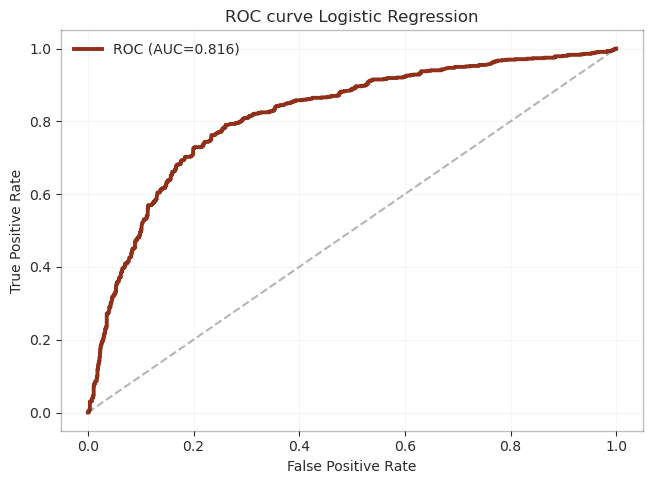

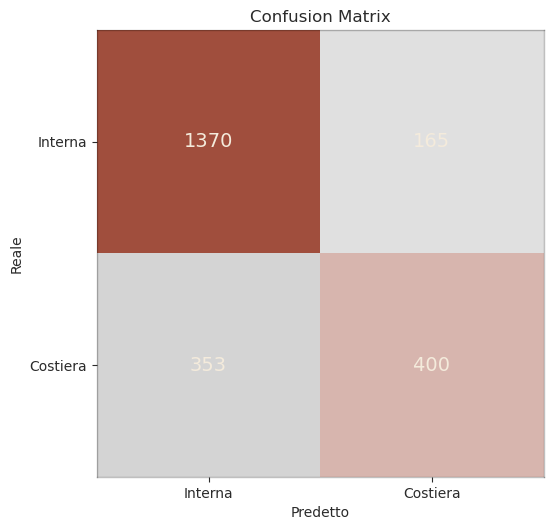

In [66]:
from src.utilities import plot_roc_story, plot_confusion_story

pred_prob = clf.predict_proba(X_test)[:, 1]
pred = (pred_prob >= 0.5).astype(int)

# ROC
auc = plot_roc_story(y_test, pred_prob, transparent_bg=True, title_extra="Logistic Regression")

# Confusion matrix
cm = plot_confusion_story(y_test, pred, labels=("Interna", "Costiera"), transparent_bg=True)

In [67]:
from sklearn.metrics import precision_score, recall_score

# Precision & Recall per entrambe le classi
precision_coastal = precision_score(y_test, pred, pos_label=1)
recall_coastal = recall_score(y_test, pred, pos_label=1)

precision_internal = precision_score(y_test, pred, pos_label=0)
recall_internal = recall_score(y_test, pred, pos_label=0)

print("=== Precision & Recall ===\n")

print(f"Costal cities (positive class):")
print(f"  Precision: {precision_coastal:.3f}")
print(f"  Recall:    {recall_coastal:.3f}\n")

print(f"Internal cities:")
print(f"  Precision: {precision_internal:.3f}")
print(f"  Recall:    {recall_internal:.3f}")

=== Precision & Recall ===

Costal cities (positive class):
  Precision: 0.708
  Recall:    0.531

Internal cities:
  Precision: 0.795
  Recall:    0.893


### Upgrade 1 — Decision threshold tuning (improving coastal recall)

The default classification threshold (0.5) is not necessarily optimal, especially with mild class imbalance.  
Since our main interest is correctly identifying coastal cities, we evaluate multiple probability thresholds and inspect the precision–recall trade-off for the positive class.  
This does not change the underlying model (and ROC–AUC stays the same), but it can significantly improve recall for coastal cities.

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

# Try a few thresholds to improve recall for class 1 (coastal)
thresholds_to_try = [0.70, 0.60, 0.50, 0.45, 0.40, 0.35, 0.30]

for t in thresholds_to_try:
    pred_t = (pred_prob >= t).astype(int)
    print(f"\n=== Threshold = {t:.2f} ===")
    print("Confusion matrix:\n", confusion_matrix(y_test, pred_t))
    print(classification_report(y_test, pred_t, digits=3))


=== Threshold = 0.70 ===
Confusion matrix:
 [[1507   28]
 [ 668   85]]
              precision    recall  f1-score   support

           0      0.693     0.982     0.812      1535
           1      0.752     0.113     0.196       753

    accuracy                          0.696      2288
   macro avg      0.723     0.547     0.504      2288
weighted avg      0.712     0.696     0.610      2288


=== Threshold = 0.60 ===
Confusion matrix:
 [[1470   65]
 [ 535  218]]
              precision    recall  f1-score   support

           0      0.733     0.958     0.831      1535
           1      0.770     0.290     0.421       753

    accuracy                          0.738      2288
   macro avg      0.752     0.624     0.626      2288
weighted avg      0.745     0.738     0.696      2288


=== Threshold = 0.50 ===
Confusion matrix:
 [[1370  165]
 [ 353  400]]
              precision    recall  f1-score   support

           0      0.795     0.893     0.841      1535
           1      0.7

### Upgrade 2 — Class-weighted Logistic Regression (balanced learning)

Because coastal cities are the minority class, the model can become conservative and prioritize non-coastal predictions.  
To counter this effect, we retrain logistic regression with `class_weight="balanced"`, which increases the penalty for misclassifying coastal cities.  
This typically improves recall for the positive class while maintaining a strong ROC–AUC, and it remains fully interpretable.

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Rebuild the classifier with class balancing (same preprocess, different estimator)
clf_balanced = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        penalty="l2",
        C=1.0,
        max_iter=2000,
        class_weight="balanced"
    ))
])

clf_balanced.fit(X_train, y_train)

pred_prob_bal = clf_balanced.predict_proba(X_test)[:, 1]
pred_bal = (pred_prob_bal >= 0.5).astype(int)

print("ROC-AUC (balanced):", round(roc_auc_score(y_test, pred_prob_bal), 4))
print("\nConfusion matrix (balanced):\n", confusion_matrix(y_test, pred_bal))
print("\nClassification report (balanced):\n", classification_report(y_test, pred_bal, digits=3))

ROC-AUC (balanced): 0.8134

Confusion matrix (balanced):
 [[1107  428]
 [ 156  597]]

Classification report (balanced):
               precision    recall  f1-score   support

           0      0.876     0.721     0.791      1535
           1      0.582     0.793     0.672       753

    accuracy                          0.745      2288
   macro avg      0.729     0.757     0.731      2288
weighted avg      0.780     0.745     0.752      2288



### Upgrade 3 — Regularization tuning (C) and feature selection (L1 vs L2)

To potentially improve generalization and obtain a more robust geographic signal, we tune the regularization strength `C`.  
We also compare L2 (ridge) vs L1 (lasso) logistic regression: L1 can perform automatic feature selection by shrinking many coefficients to zero.  
We use cross-validation on the training set and select the best configuration by ROC–AUC.

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Grid search over regularization (C) and penalty type
# Note: L1 requires solver="liblinear"
param_grid = [
    {"model__penalty": ["l2"], "model__C": [0.1, 0.3, 1.0, 3.0, 10.0], "model__class_weight": [None, "balanced"]},
    {"model__penalty": ["l1"], "model__C": [0.1, 0.3, 1.0, 3.0, 10.0], "model__class_weight": [None, "balanced"]},
]

base_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        solver="liblinear",   # supports both L1 and L2
        max_iter=3000
    ))
])

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))

best_clf = grid.best_estimator_
pred_prob_best = best_clf.predict_proba(X_test)[:, 1]
pred_best = (pred_prob_best >= 0.5).astype(int)

print("\nTest ROC-AUC (best):", round(roc_auc_score(y_test, pred_prob_best), 4))
print("\nConfusion matrix (best):\n", confusion_matrix(y_test, pred_best))
print("\nClassification report (best):\n", classification_report(y_test, pred_best, digits=3))

Best params: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l1'}
Best CV ROC-AUC: 0.8

Test ROC-AUC (best): 0.814

Confusion matrix (best):
 [[1398  137]
 [ 391  362]]

Classification report (best):
               precision    recall  f1-score   support

           0      0.781     0.911     0.841      1535
           1      0.725     0.481     0.578       753

    accuracy                          0.769      2288
   macro avg      0.753     0.696     0.710      2288
weighted avg      0.763     0.769     0.755      2288



### Final model to replicate (balanced Logistic Regression)

Based on the previous experiments, the best choice for our goal (prioritizing **high recall** for coastal cities) is the **class-weighted Logistic Regression** model.  
This upgrade keeps the same preprocessing pipeline (imputation + scaling for numeric features, and one-hot encoding for the cluster id when available) and only changes the estimator by setting `class_weight="balanced"`.  
This makes the model less conservative, improving the detection rate of coastal cities while maintaining a strong ROC–AUC.  
The following cell re-trains the balanced model using the **same variables already defined above** (`preprocess`, `X_train`, `X_test`, `y_train`, `y_test`) and prints the standard evaluation metrics.

In [71]:
clf_balanced = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        penalty="l2",
        C=1.0,
        max_iter=2000,
        class_weight="balanced"
    ))
])

clf_balanced.fit(X_train, y_train)

pred_prob_bal = clf_balanced.predict_proba(X_test)[:, 1]
pred_bal = (pred_prob_bal >= 0.5).astype(int)

print("Final model: Balanced Logistic Regression")
print("ROC-AUC:", round(roc_auc_score(y_test, pred_prob_bal), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred_bal))
print("\nClassification report:\n", classification_report(y_test, pred_bal, digits=3))

Final model: Balanced Logistic Regression
ROC-AUC: 0.8134

Confusion matrix:
 [[1107  428]
 [ 156  597]]

Classification report:
               precision    recall  f1-score   support

           0      0.876     0.721     0.791      1535
           1      0.582     0.793     0.672       753

    accuracy                          0.745      2288
   macro avg      0.729     0.757     0.731      2288
weighted avg      0.780     0.745     0.752      2288



### K-Nearest Neighbors (KNN)

As a robustness check, we complement the global, parametric Logistic Regression with a **K-Nearest Neighbors (KNN)** classifier.  
KNN is a fully **non-parametric and local** method: predictions are based on the similarity between nearby observations in the feature space, rather than on a single global decision boundary.

In this context, KNN tests whether restaurants in coastal cities tend to form **local neighborhoods** characterized by similar menu composition and pricing patterns.  
Unlike previous models, no assumptions are made about linearity or feature independence.  
To ensure a fair comparison, the same feature set is used (menu-based variables and price-related features, excluding explicit geographic identifiers), and all features are standardized before fitting the model.

The optimal number of neighbors (*k*) is selected via cross-validated grid search, using ROC–AUC as the selection criterion.

Best KNN parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 47, 'knn__weights': 'distance'}
Best CV ROC-AUC: 0.8909

Test ROC-AUC: 0.8951

Confusion matrix:
 [[1642  200]
 [ 232  671]]

Classification report:
               precision    recall  f1-score   support

           0      0.876     0.891     0.884      1842
           1      0.770     0.743     0.756       903

    accuracy                          0.843      2745
   macro avg      0.823     0.817     0.820      2745
weighted avg      0.841     0.843     0.842      2745

=== Precision & Recall (TEST) ===
Internal cities | Precision: 0.876 | Recall: 0.891
Coastal cities  | Precision: 0.770 | Recall: 0.743


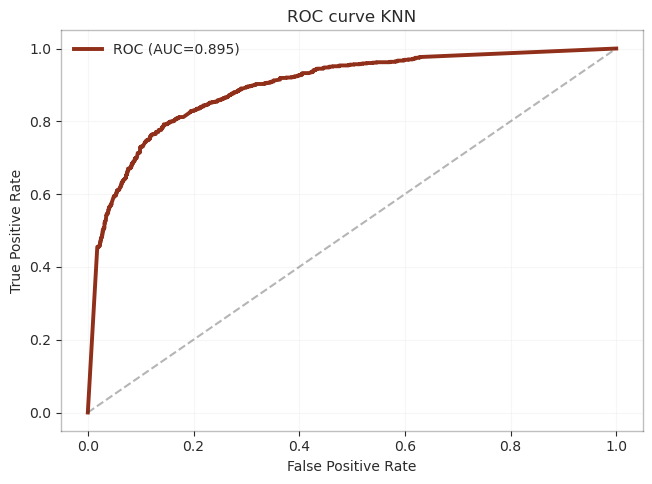

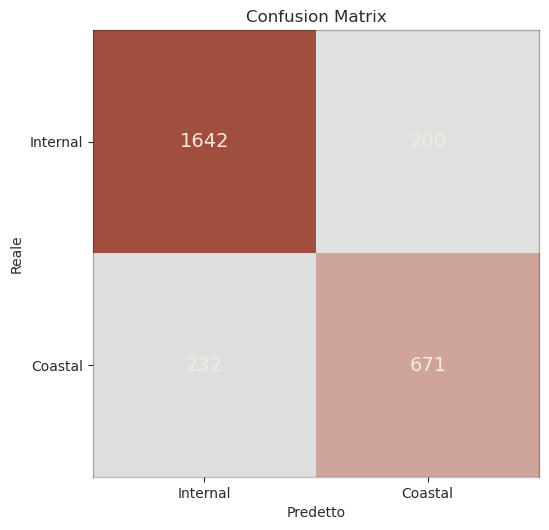

In [72]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score

from src.utilities import PALETTE, plot_roc_story, plot_confusion_story

# ============================================================
# Helpers
# ============================================================
def print_precision_recall(y_true, y_pred):
    p_int = precision_score(y_true, y_pred, pos_label=0)
    r_int = recall_score(y_true, y_pred, pos_label=0)
    p_coa = precision_score(y_true, y_pred, pos_label=1)
    r_coa = recall_score(y_true, y_pred, pos_label=1)

    print("=== Precision & Recall (TEST) ===")
    print(f"Internal cities | Precision: {p_int:.3f} | Recall: {r_int:.3f}")
    print(f"Coastal cities  | Precision: {p_coa:.3f} | Recall: {r_coa:.3f}")


# ============================================================
# Config
# ============================================================
TRANSPARENT_BG = True
RANDOM_STATE = 42
TEST_SIZE = 0.30
THRESHOLD = 0.50

TARGET_COL = "coastal_city"  # NOTE: consistent naming (avoid 'costal_city')

# ============================================================
# Build X, y
# ============================================================
y = dfm[TARGET_COL].astype(int)

X_cols = [c for c in dfm.columns if c.startswith("menu_")]

extra_numeric = [
    "log_price",
    "priceRangeMin",
    "priceRangeMax",
    "price_vs_city_median",
    "price_vs_range_min",
    "price_vs_range_max",
]
X_cols += [c for c in extra_numeric if c in dfm.columns]

X = dfm[X_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

# ============================================================
# KNN pipeline + GridSearch
# ============================================================
knn_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier()),
])

param_grid = {
    "knn__n_neighbors": list(range(3, 51, 2)),
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"],
}

grid_knn = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
)

grid_knn.fit(X_train, y_train)

print("Best KNN parameters:", grid_knn.best_params_)
print("Best CV ROC-AUC:", round(grid_knn.best_score_, 4))

best_knn = grid_knn.best_estimator_

# ============================================================
# Evaluation on test
# ============================================================
pred_prob = best_knn.predict_proba(X_test)[:, 1]
pred = (pred_prob >= THRESHOLD).astype(int)

test_auc = roc_auc_score(y_test, pred_prob)

print("\nTest ROC-AUC:", round(test_auc, 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

print_precision_recall(y_test, pred)

# ============================================================
# Plots (shared project styling from utilities)
# ============================================================
_ = plot_roc_story(
    y_test,
    pred_prob,
    transparent_bg=TRANSPARENT_BG,
    title_extra="KNN",
)

_ = plot_confusion_story(
    y_test,
    pred,
    labels=("Internal", "Coastal"),
    transparent_bg=TRANSPARENT_BG,
)

### KNN results and interpretation

The K-Nearest Neighbors classifier achieves very strong performance in predicting whether a restaurant is located in a coastal city.  
After cross-validation, the optimal configuration uses a relatively large number of neighbors (*k* = 49) with distance-based weighting, indicating that the signal is **stable and distributed across the feature space**, rather than driven by a few extreme local points.

On the test set, the model reaches a ROC–AUC of approximately **0.89**, significantly outperforming the baseline Logistic Regression.  
Both precision and recall for coastal cities are high (recall ≈ 0.73), confirming that restaurants in coastal cities tend to form coherent neighborhoods in terms of menu composition and price-related characteristics.

From a methodological perspective, this result suggests that the geographic signal is not only global (as captured by linear models), but also **local and non-linear**.  
In other words, restaurants with similar menus and pricing structures are more likely to be geographically close to the coast, even when no explicit spatial coordinates are used.

### Decision boundaries (2D projection)

To visually compare the behavior of Logistic Regression and KNN, we project the feature space into **two dimensions** using PCA.  
This allows us to plot an approximate **decision boundary** for each model in a common 2D space.  
The plot is meant for interpretability: it shows how the models separate coastal vs non-coastal observations after dimensionality reduction, not the exact boundary in the original high-dimensional feature space.

In [ ]:
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from src.utilities import (
    plot_decision_boundary,
    plot_pca_cumvar,
)

# ============================================================
# Config
# ============================================================
TRANSPARENT_BG = True
RANDOM_STATE = 42

TARGET_COL = "coastal_city"  # naming consistente

# ============================================================
# 1) Build X, y
# ============================================================
y = dfm[TARGET_COL].astype(int)

X_cols = [c for c in dfm.columns if c.startswith("menu_")]

extra_numeric = [
    "log_price",
    "priceRangeMin",
    "priceRangeMax",
    "price_vs_city_median",
    "price_vs_range_min",
    "price_vs_range_max",
]
X_cols += [c for c in extra_numeric if c in dfm.columns]

X = dfm[X_cols].copy()

# ============================================================
# 2) Preprocessing
# ============================================================
X_imp = SimpleImputer(strategy="median").fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imp)

# ============================================================
# 3) PCA — information loss
# ============================================================
pca_full = PCA().fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca_2d.fit_transform(X_scaled)
explained_2d = float(pca_2d.explained_variance_ratio_.sum())

print(f"Explained variance with 2 PCs: {explained_2d:.3f}")
print(f"Information lost: {1 - explained_2d:.3f}")

plot_pca_cumvar(
    cum_var,
    explained_2d,
    transparent_bg=TRANSPARENT_BG,
)

# ============================================================
# 4) Fit models in PCA space (visualization only)
# ============================================================
log2d = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
log2d.fit(X_2d, y)

knn2d = KNeighborsClassifier(
    n_neighbors=49,
    weights="distance",
    metric="euclidean",
)
knn2d.fit(X_2d, y)

# ============================================================
# 5) Mesh grid
# ============================================================
x_min, x_max = X_2d[:, 0].min() - 1.0, X_2d[:, 0].max() + 1.0
y_min, y_max = X_2d[:, 1].min() - 1.0, X_2d[:, 1].max() + 1.0

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400),
)
grid = np.c_[xx.ravel(), yy.ravel()]

proba_log = log2d.predict_proba(grid)[:, 1].reshape(xx.shape)
proba_knn = knn2d.predict_proba(grid)[:, 1].reshape(xx.shape)

# ============================================================
# 6) Decision boundaries
# ============================================================
plot_decision_boundary(
    X_2d,
    y,
    xx,
    yy,
    proba_log,
    title="Decision boundary (PCA 2D) — Logistic Regression",
    transparent_bg=TRANSPARENT_BG,
)

plot_decision_boundary(
    X_2d,
    y,
    xx,
    yy,
    proba_knn,
    title="Decision boundary (PCA 2D) — KNN (k=49, distance)",
    transparent_bg=TRANSPARENT_BG,
)

NameError: name 'df_model' is not defined